# Let's make popular beers

## Preprocessing data

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import scipy.stats as stats


sns.set_style("darkgrid")
%matplotlib inline

from sklearn import preprocessing

from bokeh.models import TabPanel, Tabs, Label
from bokeh.io import show, output_file
from bokeh.plotting import figure
from bokeh.models import Span, ColumnDataSource
import collections

import spacy

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import statsmodels.formula.api as smf

In [2]:
df_rating_rb = pd.read_csv('../projectM1/after_pro_data_rb.csv')
df_rating_rb.rating.head()

0    2.9
1    3.2
2    3.2
3    3.9
4    3.6
Name: rating, dtype: float64

<AxesSubplot:ylabel='Frequency'>

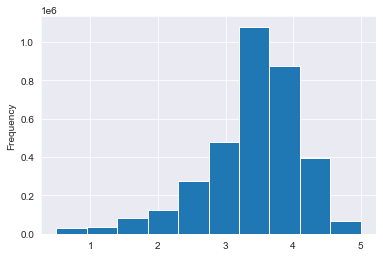

In [3]:
df_rating_rb.rating.plot.hist()

In [4]:
df_rating_ba = pd.read_csv('../projectM1/after_pro_data_ba.csv')

<AxesSubplot:ylabel='Frequency'>

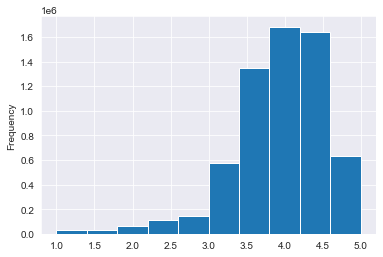

In [5]:
df_rating_ba.rating.plot.hist()

In [6]:
stats.ttest_ind(a=df_rating_rb.rating, b=df_rating_ba.rating)

Ttest_indResult(statistic=-1229.4018122014832, pvalue=0.0)

### Handle the missing value and initial data filtering

In this part, we will handle the missing value and initial data filtering.

In [7]:
# Load ratings data from BeerAdvocate
# df_rating_ba = pd.read_csv('./data/after_pro_data_ba.csv')
df_rating_ba = df_rating_ba.drop(columns=['Unnamed: 0'])
print(f'Currently, there are {len(df_rating_ba)} ratings on BeerAdvocate website')
df_rating_ba.head()

Currently, there are 6264473 ratings on BeerAdvocate website


beer_name  beer_id                brewery_name  brewery_id  \
0  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
1  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
2  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
3  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
4  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   

           style  abv        date        user_name                  user_id  \
0  Irish Red Ale  3.8  1500112800  GregKobeArntz24  gregkobearntz24.1206160   
1  Irish Red Ale  3.8  1483182000           awjess           awjess.1185716   
2  Irish Red Ale  3.8  1468317600          fr0wn3r           fr0wn3r.862994   
3  Irish Red Ale  3.8  1459418400       Fatehunter        fatehunter.326927   
4  Irish Red Ale  3.8  1450263600           MTLDOG            mtldog.920333   

   appearance  aroma  palate  taste  overall  rating  \
0         4.5   4.75    4.25    4.5     4.50    4.54   
1         4.5   4.00    4.25    4.0     4.25    4.11   
2         3.0   3.25    3.00    3.0     3.00    3.06   
3         4.0   3.25    4.00    3.5     3.50    3.52   
4         4.5   3.75    4.00    3.0     3.75    3.52   

                                                text  review  
0                                                NaN   False  
1  Look - Has a nice foamy head,   Feel - Creamy ...   False  
2                                                NaN   False  
3  Pours a finger of head on a hazy darker straw ...    True  
4                                                NaN   False

In [8]:
# The scoring attribute
column_ = ['appearance', 'aroma', 'palate', 'taste', 'overall']
print(f'There are {df_rating_ba [column_].isna().any(axis = 1).value_counts()[1]} rows have NAN values in BeerAdvocate')
print(f'There are {np.sum(df_rating_ba [column_].isna().sum(axis = 1)==5)} rows with 5 NAN values in BeerAdvocate')
compare_ba = df_rating_ba[df_rating_ba[column_].isna().any(axis = 1)]
compare_ba['rating'].describe()

There are 2971642 rows have NAN values in BeerAdvocate
There are 2971642 rows with 5 NAN values in BeerAdvocate


count    2.971642e+06
mean     3.902421e+00
std      6.835105e-01
min      1.000000e+00
25%      3.500000e+00
50%      4.000000e+00
75%      4.250000e+00
max      5.000000e+00
Name: rating, dtype: float64

Here we found if there is no overall score, there wouldn't be detailed scores about one beer. We also check the website manually, and found that we should rate the appearance, aroma, palate, taste, overall together.
However, these data all have the rating values. We don't think that these data are useful since we want to find some relationship of the detailed score to the rating and other perspectives. And since we will still have very large amout data after deleting them, we will just simply delete them.

In [9]:
#Delete all meaningless lines
df_rating_ba = df_rating_ba[~df_rating_ba[column_].isna().any(axis = 1)]
df_rating_ba.shape

(3292831, 17)

In [10]:
#spilt the user_id in BeerAdvocate
def str_split(data):
    return data.split('.')[1]
df_rating_ba['user_id'] = df_rating_ba['user_id'].apply(str_split)
df_rating_ba.head()

beer_name  beer_id                brewery_name  brewery_id  \
0  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
1  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
2  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
3  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
4  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   

           style  abv        date        user_name  user_id  appearance  \
0  Irish Red Ale  3.8  1500112800  GregKobeArntz24  1206160         4.5   
1  Irish Red Ale  3.8  1483182000           awjess  1185716         4.5   
2  Irish Red Ale  3.8  1468317600          fr0wn3r   862994         3.0   
3  Irish Red Ale  3.8  1459418400       Fatehunter   326927         4.0   
4  Irish Red Ale  3.8  1450263600           MTLDOG   920333         4.5   

   aroma  palate  taste  overall  rating  \
0   4.75    4.25    4.5     4.50    4.54   
1   4.00    4.25    4.0     4.25    4.11   
2   3.25    3.00    3.0     3.00    3.06   
3   3.25    4.00    3.5     3.50    3.52   
4   3.75    4.00    3.0     3.75    3.52   

                                                text  review  
0                                                NaN   False  
1  Look - Has a nice foamy head,   Feel - Creamy ...   False  
2                                                NaN   False  
3  Pours a finger of head on a hazy darker straw ...    True  
4                                                NaN   False

### Datasets preparation and more filtering

We first map the scale of each rating to 0-5 to make a consistency between the two datasets.

In [11]:
column_list = ['appearance', 'aroma', 'palate', 'taste', 'overall','rating']
list_value = df_rating_ba[column_list].values
min_max_scaler = preprocessing.MinMaxScaler()
list_value_scaler = min_max_scaler.fit_transform(list_value) * 5
data_temp_ba = pd.DataFrame(list_value_scaler,columns=column_list,index = df_rating_ba.index)
df_rating_ba[column_list] = data_temp_ba

df_rating_ba.head()

beer_name  beer_id                brewery_name  brewery_id  \
0  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
1  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
2  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
3  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
4  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   

           style  abv        date        user_name  user_id  appearance  \
0  Irish Red Ale  3.8  1500112800  GregKobeArntz24  1206160       4.375   
1  Irish Red Ale  3.8  1483182000           awjess  1185716       4.375   
2  Irish Red Ale  3.8  1468317600          fr0wn3r   862994       2.500   
3  Irish Red Ale  3.8  1459418400       Fatehunter   326927       3.750   
4  Irish Red Ale  3.8  1450263600           MTLDOG   920333       4.375   

    aroma  palate  taste  overall  rating  \
0  4.6875  4.0625  4.375   4.3750  4.4250   
1  3.7500  4.0625  3.750   4.0625  3.8875   
2  2.8125  2.5000  2.500   2.5000  2.5750   
3  2.8125  3.7500  3.125   3.1250  3.1500   
4  3.4375  3.7500  2.500   3.4375  3.1500   

                                                text  review  
0                                                NaN   False  
1  Look - Has a nice foamy head,   Feel - Creamy ...   False  
2                                                NaN   False  
3  Pours a finger of head on a hazy darker straw ...    True  
4                                                NaN   False

By doing some simple regression study we find there exist perfect linear relationship between 'overall', 'aroma', 'palate', 'taste', 'overall', 'rating'.

In [12]:
# Use linear regression to fit our data
mod_ba = smf.ols(formula='rating ~appearance + aroma + palate + taste + overall',data = df_rating_ba)
res_ba = mod_ba.fit()
print(res_ba.summary())
print(f'The R-squared is 1.000 so it is of perfect linear relationship.')

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.904e+10
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:45:13   Log-Likelihood:             1.4883e+07
No. Observations:             3292831   AIC:                        -2.977e+07
Df Residuals:                 3292825   BIC:                        -2.977e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0003    8.3e-06     37.210      0.0

We also find that there exists some ratings that the **overall** score exceeds the average of the other 4 features(can do this due to the perfect linear relationship). We consider this situation as invalid ratings. Because in common sense, if the detailed features of a beer is good/bad the overall will not be bad/good. And we set the difference threshold to 1.5(in scale of 5).

In [13]:
df_rating_ba['average'] = df_rating_ba[['appearance','aroma','palate','taste']].mean(axis = 1)
df_rating_ba['diff'] = np.abs(df_rating_ba['overall']-df_rating_ba['average'])
df_rating_ba = df_rating_ba[df_rating_ba['diff'] <1.5]
df_rating_ba = df_rating_ba.drop(columns=['average','diff'])
df_rating_ba.shape

(3266748, 17)

In addition, our analysis will based on the review text later, so we just consider the review as invalid, if there is no text in the review column.

In [14]:
df_rating_ba = df_rating_ba[~df_rating_ba['review']==False]
df_rating_ba.shape

(1855976, 17)

In [15]:
# Load user data from BeerAdvocate
df_user_ba = pd.read_csv('../projectM1/BeerAdvocate/users.csv')
df_user_ba['user_id'] = df_user_ba['user_id'].apply(str_split)
df_user_ba.head()

nbr_ratings  nbr_reviews user_id        user_name        joined  \
0         7820          465  184925          nmann08  1.199704e+09   
1         2521         2504  163714      StJamesGate  1.191838e+09   
2         1797         1143   19527          mdagnew  1.116410e+09   
3           31           31   10867  helloloser12345  1.101380e+09   
4          604          604    3708       cypressbob  1.069326e+09   

                    location  
0  United States, Washington  
1    United States, New York  
2           Northern Ireland  
3           Northern Ireland  
4           Northern Ireland

In [16]:
# Load beer data from BeerAdvocate
df_beer_ba = pd.read_csv('../projectM1/BeerAdvocate/beers.csv')
df_beer_ba.head()

beer_id           beer_name  brewery_id            brewery_name  \
0   166064    Nashe Moskovskoe       39912  Abdysh-Ata (Абдыш Ата)   
1   166065     Nashe Pivovskoe       39912  Abdysh-Ata (Абдыш Ата)   
2   166066  Nashe Shakhterskoe       39912  Abdysh-Ata (Абдыш Ата)   
3   166067  Nashe Zhigulevskoe       39912  Abdysh-Ata (Абдыш Ата)   
4   166063              Zhivoe       39912  Abdysh-Ata (Абдыш Ата)   

             style  nbr_ratings  nbr_reviews  avg  ba_score  bros_score  abv  \
0  Euro Pale Lager            0            0  NaN       NaN         NaN  4.7   
1  Euro Pale Lager            0            0  NaN       NaN         NaN  3.8   
2  Euro Pale Lager            0            0  NaN       NaN         NaN  4.8   
3  Euro Pale Lager            0            0  NaN       NaN         NaN  4.0   
4  Euro Pale Lager            0            0  NaN       NaN         NaN  4.5   

   avg_computed  zscore  nbr_matched_valid_ratings  avg_matched_valid_ratings  
0           NaN     NaN                          0                        NaN  
1           NaN     NaN                          0                        NaN  
2           NaN     NaN                          0                        NaN  
3           NaN     NaN                          0                        NaN  
4           NaN     NaN                          0                        NaN

In [17]:
# Load brewery data from BeerAdvocate
df_brewery_ba = pd.read_csv('../projectM1/BeerAdvocate/breweries.csv')
df_brewery_ba.head()

id    location                    name  nbr_beers
0  39912  Kyrgyzstan  Abdysh-Ata (Абдыш Ата)          5
1  39913  Kyrgyzstan             Arpa (АРПА)          1
2  39914  Kyrgyzstan               Bear Beer          4
3  39915  Kyrgyzstan             Blonder Pub          4
4  39916  Kyrgyzstan            Kellers Bier          2

Merge data based on user id in order to get users' location

In [18]:
#user_region = df_user_ba[['user_id', 'location']]
region_ba = pd.merge(df_rating_ba, df_user_ba, how="left", left_on='user_id', right_on='user_id')

In [19]:
region_agg = region_ba[['location', 'beer_id']].groupby('location').agg('count')
region_agg = pd.DataFrame(region_agg.to_records())
region_agg.rename(columns={'beer_id':'count'}, inplace=True)
region_agg = region_agg.sort_values(by=['count'], ascending=False)
region_agg.reset_index(inplace=True, drop=True)
# Print top 20 region
region_agg.head(20)

location   count
0     United States, Pennsylvania  148288
1       United States, California  137656
2         United States, New York  115045
3         United States, Illinois  100887
4    United States, Massachusetts   97904
5             United States, Ohio   83572
6            United States, Texas   66150
7                          Canada   64502
8       United States, New Jersey   61711
9         United States, Virginia   57073
10       United States, Minnesota   56909
11      United States, Washington   53248
12  United States, North Carolina   49830
13         United States, Florida   49441
14        United States, Michigan   48911
15        United States, Colorado   46906
16         United States, Georgia   40426
17        United States, Maryland   40238
18       United States, Wisconsin   35537
19     United States, Connecticut   33720

In [20]:
region_ba

beer_name  beer_id                           brewery_name  \
0        Caffrey's Irish Ale      825             Thomas Caffrey Brewing Co.   
1        Caffrey's Irish Ale      825             Thomas Caffrey Brewing Co.   
2        Caffrey's Irish Ale      825             Thomas Caffrey Brewing Co.   
3        Caffrey's Irish Ale      825             Thomas Caffrey Brewing Co.   
4        Caffrey's Irish Ale      825             Thomas Caffrey Brewing Co.   
...                      ...      ...                                    ...   
1856261       Old Horizontal     1009  Victory Brewing Company - Downingtown   
1856262       Old Horizontal     1009  Victory Brewing Company - Downingtown   
1856263       Old Horizontal     1009  Victory Brewing Company - Downingtown   
1856264       Old Horizontal     1009  Victory Brewing Company - Downingtown   
1856265       Old Horizontal     1009  Victory Brewing Company - Downingtown   

         brewery_id                style   abv        date     user_name_x  \
0               297        Irish Red Ale   3.8  1459418400      Fatehunter   
1               297        Irish Red Ale   3.8  1406368800         chogm54   
2               297        Irish Red Ale   3.8  1091354400          Gusler   
3               297        Irish Red Ale   3.8  1089021600       LarryKemp   
4               297        Irish Red Ale   3.8  1083751200  JustinBathurst   
...             ...                  ...   ...         ...             ...   
1856261         345  American Barleywine  11.0  1236164400         u2carew   
1856262         345  American Barleywine  11.0  1236078000           drtth   
1856263         345  American Barleywine  11.0  1235991600         cracgor   
1856264         345  American Barleywine  11.0  1235818800        spointon   
1856265         345  American Barleywine  11.0  1235732400        Jmamay22   

        user_id  appearance  ...  taste  overall  rating  \
0        326927      3.7500  ...  3.125    3.125  3.1500   
1        766666      2.8125  ...  2.500    1.875  1.9875   
2           811      2.5000  ...  2.500    2.500  2.5000   
3           765      5.0000  ...  3.125    3.125  3.3250   
4          3835      3.1250  ...  0.625    1.250  1.2000   
...         ...         ...  ...    ...      ...     ...   
1856261  283938      3.7500  ...  3.750    3.750  3.5375   
1856262  174905      3.7500  ...  3.750    3.750  3.9000   
1856263   18847      3.7500  ...  5.000    5.000  4.6250   
1856264  175008      3.7500  ...  4.375    4.375  4.1250   
1856265   97445      3.7500  ...  2.500    2.500  2.9375   

                                                      text  review  \
0        Pours a finger of head on a hazy darker straw ...    True   
1        Pours from a 500ml can.A- clear, dark mahogany...    True   
2        The beer as its spills from the can a slightly...    True   
3        A very dark golden brown with a thick white he...    True   
4        Okay, so the beer was handed to looking quite ...    True   
...                                                    ...     ...   
1856261  (A) Pours with a nice head. Clear reddish brow...    True   
1856262  Slightly chilled and poured into Duvel glass. ...    True   
1856263  Pours out a brown but translucent beer with a ...    True   
1856264  I poured this one from a 12oz brown bottle int...    True   
1856265  Old horizontal pours a somewhat hazy ruby brow...    True   

        nbr_ratings  nbr_reviews     user_name_y        joined  \
0              2010         2000      Fatehunter  1.241431e+09   
1               323          232         chogm54  1.385636e+09   
2              2267         2267          Gusler  1.033294e+09   
3               251          251       LarryKemp  1.032602e+09   
4               148          148  JustinBathurst  1.070104e+09   
...             ...          ...             ...           ...   
1856261         763          758         u2carew  1.230980e+09   
1856262        1124         105

## Data analysis - Discover the common characteristics of the best-selling beers

Based on the data we have, we can do some visulization to see the distribution of the data. For ABV, beer style distribution, we filtered the data from 25% quantile to 75% quantile.

In [21]:
fig_width = 1000
# figure for adv
data = region_ba[np.isfinite(region_ba.abv)].abv
avg_ba_abv = region_ba.abv.mean()
avg_ba_abv = round(avg_ba_abv, 2)

hist, edges = np.histogram(data, bins=np.arange(0, 20.1, 0.5), density=True)
hist = hist * 100 # convert to percentage

p1 = figure(height = 400, width = fig_width, title = 'Abv rankings on BeerAdvocate', x_axis_label = 'Abv', y_axis_label = 'Percentage(%)')
p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="white")

vline = Span(location=avg_ba_abv, dimension='height', line_color='red', line_width=2)
vline_label = Label(text_color=vline.line_color, text=f'Average ADV.: {vline.location}', x=vline.location, y=15)

p1.renderers.extend([vline, vline_label])

p1.y_range.start = 0
p1.xaxis.major_label_text_color = 'black'  # turn off x-axis tick labels leaving space

tab1 = TabPanel(child=p1, title="ADV")

# figure for style

data = collections.Counter(region_ba['style'])
style = [x for x in data.keys()]
count = np.array([x for x in data.values()]) / len(region_ba['style']) * 100
source = ColumnDataSource({'style': style, 'count': count})


sorted_style = sorted(style, key=lambda x: count[style.index(x)])


p2 = figure(x_range=sorted_style, height = 400, width = fig_width, title = 'Beer style on BeerAdvocate', x_axis_label = 'Style', y_axis_label = 'Percentage(%)',
           tools="hover", tooltips=[('style name: ', '@style'), ('Percentage(%): ', '@count')])

p2.vbar(x='style', top='count', source=source, line_color="white")
p2.y_range.start = 0
p2.xaxis.major_label_text_color = None  # turn off x-axis tick labels leaving space

tab2 = TabPanel(child=p2, title="Style")

# figure for brewery

data = collections.Counter(region_ba['brewery_name'])
brewery_name = [x for x in data.keys()]
count = np.array([x for x in data.values()]) / len(region_ba)
source = ColumnDataSource({'brewery_name': brewery_name, 'count': count})


sorted_brewery = sorted(brewery_name, key=lambda x: count[brewery_name.index(x)])


p3 = figure(x_range=sorted_brewery, height = 400, width = fig_width, title = 'Brewery on BeerAdvocate', x_axis_label = 'Brewery Name', y_axis_label = 'Percentage(%)',
           tools="hover", tooltips=[('style name: ', '@brewery_name'), ('Percentage(%): ', '@count')])

p3.vbar(x='brewery_name', top='count', source=source)
p3.y_range.start = 0
p3.xaxis.major_label_text_color = None  # turn off x-axis tick labels leaving space

tab3 = TabPanel(child=p3, title="brewery_name")

# combine 3 tab to one panel

tabs = Tabs(tabs=[ tab1, tab2, tab3 ])
show(tabs)

# output_file('./figure/hist.html')



For abv, since we want to make the most popular beer as our motivation, we just study the beers that has abv from its 25% quantile to 75% quantile.

In [22]:
region_ba_filtered = region_ba[(region_ba.abv.quantile(0.25) <= region_ba.abv) & (region_ba.abv <= region_ba.abv.quantile(0.75))]
region_ba_filtered.shape

(1007708, 22)

In [23]:
style_list = region_ba[['style','beer_id']].groupby('style').agg('count')
style_list.rename(columns={'beer_id': 'count'}, inplace=True)
style_list = style_list.sort_values(by='count', ascending=False)
style_list.reset_index(inplace=True)
style_list.head(10)

style   count
0                      American IPA  183955
1    American Double / Imperial IPA  146798
2  American Double / Imperial Stout   95908
3           American Pale Ale (APA)   70148
4            Russian Imperial Stout   67380
5                   American Porter   54793
6            Saison / Farmhouse Ale   48686
7          American Amber / Red Ale   46612
8           Belgian Strong Dark Ale   40571
9            Fruit / Vegetable Beer   36383

For beer style, we also just want to analysis the beer styles with the top 10 popularity

In [24]:
popular_styles = style_list['style'][:10].to_list()
region_ba_filtered = region_ba_filtered[region_ba_filtered['style'].isin(popular_styles)]
region_ba_filtered.shape

(472850, 22)

## For user recommendation(Unfinished)

In this part, we designed an user recommandation system based on the user input. The model was trained by the high rating beer reviews.

define some variables that the user can input

In [25]:
abv=5.0
error_range_abv = 0.5
style = region_ba['style'].unique().tolist()[0]
region = region_agg['location'].tolist()[0]
num_of_results_to_show = 10
How = ['popularity', 'Rating']
how = {'popularity': 0, 'Rating': 1}

by popularity

In [26]:
df_beer_ba.head()

beer_id           beer_name  brewery_id            brewery_name  \
0   166064    Nashe Moskovskoe       39912  Abdysh-Ata (Абдыш Ата)   
1   166065     Nashe Pivovskoe       39912  Abdysh-Ata (Абдыш Ата)   
2   166066  Nashe Shakhterskoe       39912  Abdysh-Ata (Абдыш Ата)   
3   166067  Nashe Zhigulevskoe       39912  Abdysh-Ata (Абдыш Ата)   
4   166063              Zhivoe       39912  Abdysh-Ata (Абдыш Ата)   

             style  nbr_ratings  nbr_reviews  avg  ba_score  bros_score  abv  \
0  Euro Pale Lager            0            0  NaN       NaN         NaN  4.7   
1  Euro Pale Lager            0            0  NaN       NaN         NaN  3.8   
2  Euro Pale Lager            0            0  NaN       NaN         NaN  4.8   
3  Euro Pale Lager            0            0  NaN       NaN         NaN  4.0   
4  Euro Pale Lager            0            0  NaN       NaN         NaN  4.5   

   avg_computed  zscore  nbr_matched_valid_ratings  avg_matched_valid_ratings  
0           NaN     NaN                          0                        NaN  
1           NaN     NaN                          0                        NaN  
2           NaN     NaN                          0                        NaN  
3           NaN     NaN                          0                        NaN  
4           NaN     NaN                          0                        NaN

In [27]:
selected = df_beer_ba[df_beer_ba.abv.isin(np.linspace(abv-error_range_abv, abv+error_range_abv, 10))]

In [28]:
selected = selected[selected['style'] == style]
selected.sort_values(by='nbr_reviews', ascending=False, inplace=True)
selected_beer_id_by_popularity = selected.beer_id.tolist()[:num_of_results_to_show]
selected_beer_id_by_popularity

[29602, 16520, 1822, 71106, 43835, 47166, 2778, 7492, 9091, 79393]

by_rating_avg

In [29]:
selected = region_ba[region_ba.abv.isin(np.linspace(abv-error_range_abv, abv+error_range_abv, 10))]
selected = selected[selected['style'] == style]
selected_beer_avgRating = selected[['beer_id', 'rating']].groupby('beer_id').agg('mean')
selected_beer_avgRating.sort_values(by='rating', ascending=False, inplace=True)
selected_beer_avgRating.reset_index(inplace=True)
selected_beer_name_by_avgRating = df_beer_ba[df_beer_ba.beer_id.isin(selected_beer_avgRating['beer_id'].to_list()[:num_of_results_to_show])][['beer_id', 'beer_name']]
selected_beer_name_by_avgRating = selected_beer_name_by_avgRating.beer_id.to_list()
selected_beer_name_by_avgRating

[1822, 29602, 62182, 9091, 43835, 79393, 23052, 16520, 7492, 2778]

In [30]:
selected_id_list = [selected_beer_id_by_popularity, selected_beer_name_by_avgRating]

Here the ```selected_list``` is the beer info list that we may recommend to the user and ```selected_beer_name_by_How``` is the top ```num_of_results_to_show``` beer_id to show.

In [31]:
beer_to_show = df_beer_ba[df_beer_ba['beer_id'].isin(selected_id_list[how[How[0]]])]
beer_to_show = beer_to_show[['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style',
                             'nbr_ratings', 'nbr_reviews']]
beer_to_show['Top5 keywords'] = ''

Then we want to analyze the review texts to get the top 5 keywords for user's reference.

In [32]:
text_Series_list = []
for id in selected_id_list[how[How[0]]]:
    text_Series = region_ba[region_ba.beer_id == id]['text']
    text_Series_list.append(text_Series)


In [33]:
# now we convert all the text for the beer id to a single document.
# here the key is the selected beer id, the element is the combined txt
text_dict = {}
for idx, id in enumerate(selected_id_list[how[How[0]]]):
    text_Series = text_Series_list[idx]
    text = ""
    for txt in text_Series:
        text = text + ' ' + txt
    text_dict[id] = text

In [34]:
selected_beer_with_review = pd.DataFrame.from_dict({'beer_id': text_dict.keys(), 'review_text': text_dict.values()})
selected_beer_with_review[['top5_keywords','tokenized_txt']] = None

In [35]:
selected_beer_with_review.head()

beer_id                                        review_text top5_keywords  \
0    29602   Deep brown to amber in color.  There's a fing...          None   
1    16520   From tasting notes. A lot of Irish reds are i...          None   
2     1822   Backlog. 12 oz bottle. Never used to be a fan...          None   
3    71106   An earthy, chalky, dirty, smokey taste. All f...          None   
4    43835   Pours a deep reddish brown color with plenty ...          None   

  tokenized_txt  
0          None  
1          None  
2          None  
3          None  
4          None

In [36]:
nlp = spacy.load('en_core_web_sm')

In [37]:
selected_beer_with_review.tokenized_txt = selected_beer_with_review.review_text

In [38]:
# Remove punctuation
selected_beer_with_review["puncfree"] = selected_beer_with_review.tokenized_txt.apply(lambda text:
                                                                                      " ".join(token.lemma_ for token in nlp(text)
                                                                                               if not token.is_punct))

KeyboardInterrupt: 

In [ ]:
selected_beer_with_review.tokenized_txt = selected_beer_with_review.puncfree.apply(nlp)

In [ ]:
# Remove stopping words
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
selected_beer_with_review['punc_sw_free'] = selected_beer_with_review.tokenized_txt.apply(lambda text:
" ".join(token.lemma_ for token in text if not token in spacy_stopwords)).apply(nlp)

In [ ]:
selected_beer_with_review.tokenized_txt = selected_beer_with_review.punc_sw_free.apply(nlp)

In [51]:
selected_beer_with_review['adj'] = selected_beer_with_review.tokenized_txt.apply(lambda text: " ".join(token.lemma_ for token in text if token.pos_ == "ADJ")).apply(nlp)

In [52]:
selected_beer_with_review.adj

0    (eggshell, white, most, top, nutty, struggle, ...
1    (irish, inoffensive, odd, proper, ok, great, d...
2    (due, maltier, roasted, deep, red, little, red...
3    (earthy, chalky, dirty, little, european, roas...
4    (deep, reddish, brown, white, hoppy, typical, ...
5    (hazy, spicy, creamy, light, spicy, medium, li...
6    (nonical, surprised, seasonal, great, new, dar...
7    (herbal, back, easy, forgettable, reddish, goo...
8    (hard, average, most, perfect, light, weak, he...
9    (nice, burn, sustain, white, foamy, decent, go...
Name: adj, dtype: object

In [56]:
x = [i for i in range(1998, 2017)]
y = np.linspace(5, 10, len(x))
Y = pd.DataFrame(x, y).reset_index()

X = [i for i in range(100)] ## 往后预测多少年
fh = ForecastingHorizon(X, is_relative=True)
forecaster = ThetaForecaster(sp=1)
forecaster.fit(y=Y)
y_pred = forecaster.predict(fh = fh)

In [57]:
X = [i for i in range(100)] ## 往后预测多少年
fh = ForecastingHorizon(X, is_relative=True)
forecaster = ThetaForecaster(sp=1)
forecaster.fit(y=Y)
y_pred = forecaster.predict(fh = fh)

In [58]:
y_pred

index       0
18    9.861111  2015.5
19   10.277778  2017.0
20   10.416667  2017.5
21   10.555556  2018.0
22   10.694444  2018.5
..         ...     ...
113  23.333333  2064.0
114  23.472222  2064.5
115  23.611111  2065.0
116  23.750000  2065.5
117  23.888889  2066.0

[100 rows x 2 columns]

## Data analysis - Explore popular beer trend over time

In this part, we want to investigate investigate top 3 style with the most number of reviews.

In [39]:
# make a copy of the dataframe, only retain the useful columns
df = region_ba_filtered.copy()
df = df.drop(columns=['user_name_y','review','joined','text','user_name_x','user_id'])
df['date'] = df.date.apply(lambda x: datetime.datetime.fromtimestamp(x).year)

In [40]:
# select the top 3 styles
style_top_3 = df.groupby('style').count().reset_index().sort_values(by = 'beer_name', ascending=False)[['style']][:3]['style'].to_list()
style_top_3

['American IPA', 'American Double / Imperial IPA', 'American Porter']

By previous study the year ranges from 1998 to 2017

In [41]:
year_list = [i+1998 for i in range(20)]

In [42]:
# count the number of the top 3 styles in each year
temp_dict = {}
for style in style_top_3:
    temp_dict[style] = []
    for year in year_list:
        tempdf = df[df['style'] == style]
        year_count = len(tempdf[tempdf['date']==year])
        temp_dict[style].append(year_count)

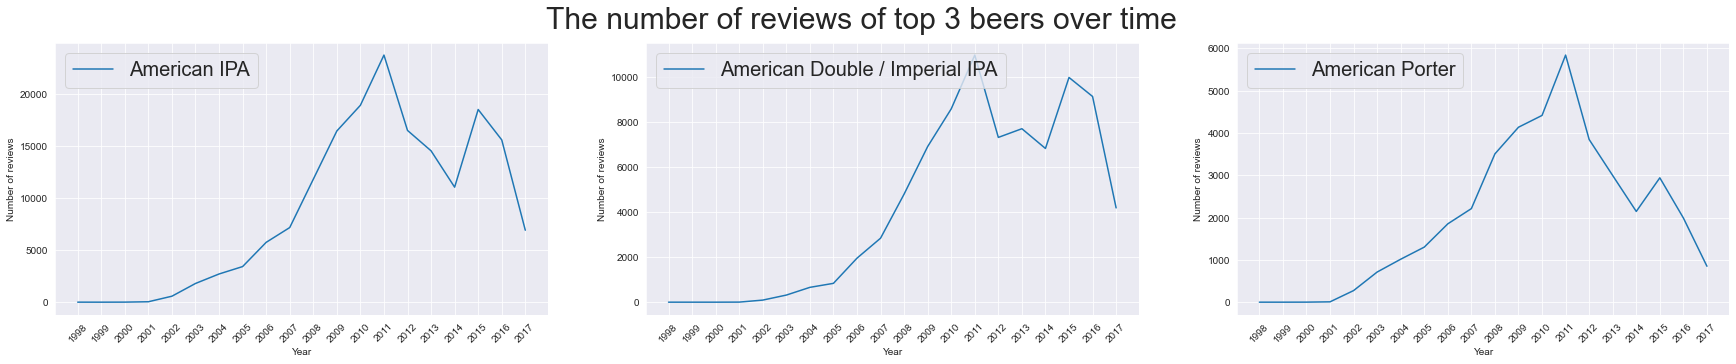

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(30,5))
for idx, key in enumerate(temp_dict.keys()):
    count = pd.DataFrame(temp_dict[key], year_list)
    sns.lineplot(x=count.index.values.astype(str), y=count[0], data=count, ax = ax[idx], legend=True, label= key, palette='rainbow')
    ax[idx].legend(prop={'size': 20})
    ax[idx].set_ylabel('Number of reviews')
    ax[idx].set_xlabel('Year')
    ax[idx].set_xticklabels(count.index.values.astype(str), rotation=45)
fig.suptitle("The number of reviews of top 3 beers over time ", fontsize=30)
plt.show()

The interesting phenomenon shows that the number of review decreases after 2010. In order to find the reason for the change, we tried to look at the proportion of reviews and compare them with the number of reviews each year.

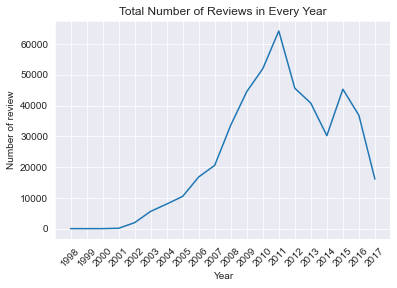

In [44]:
temp_list = []
for year in year_list:
    year_count = len(df[df['date']==year])
    temp_list.append(year_count)
temp_list = pd.DataFrame(temp_list, year_list)
sns.lineplot(x=temp_list.index.astype(str), y=temp_list[0], data=temp_list)
plt.xticks(count.index.values.astype(str), rotation=45)
plt.ylabel("Number of review")
plt.xlabel("Year")
plt.title("Total Number of Reviews in Every Year")
plt.show()

We can see that the total number of reviews is also decreasing, This may due to the number of active users on the website is decreasing. To factor this effect out, we use the fraction of the number of reviews of each style.

In [45]:
def plot_style_style_frac_worldwide(style_top_3=style_top_3, year_list=year_list, prediction=False):
    fraction_dict_top3_style = {}
    for style in style_top_3:
        fraction_dict_top3_style[style] = []
        for year in year_list:
            year_tot = len(df[df.date == year])
            tempdf = df[df['style'] == style]
            year_frac = len(tempdf[tempdf['date']==year]) / year_tot
            fraction_dict_top3_style[style].append(year_frac)
    year_to_plot = year_list
    Y_to_plot = fraction_dict_top3_style
    if prediction:
        for style in style_top_3:
            x = year_list# train data x
            y = fraction_dict_top3_style[style]
            y = [i+1 for i in y]
            Y = pd.DataFrame(x, y).reset_index()

            X = [i for i in range(1,10)] ## 往后预测多少年
            fh = ForecastingHorizon(X, is_relative=True)
            forecaster = ThetaForecaster(sp=2)
            forecaster.fit(y=Y)
            y_pred = forecaster.predict(fh = fh)
            year_to_plot = year_list + [year_list[-1]] + y_pred[0].to_list()
            Y_to_plot[style].append(Y_to_plot[style][-1])
            Y_to_plot[style].extend(y_pred['index']-1)

    fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15,5))
    for idx, key in enumerate(Y_to_plot.keys()):
        count = pd.DataFrame(Y_to_plot[key], year_to_plot)
        # print(count.index)
        # print(count[0])
        sns.lineplot(x=count.index[:len(year_list)], y=count[0].iloc[:len(year_list)], data=count.iloc[:len(year_list)], ax = ax[idx], legend=True, label= key, palette="rainbow")
        sns.lineplot(x=count.index[len(year_list):], y=count[0].iloc[len(year_list):], data=count.iloc[len(year_list):], ax = ax[idx], legend=True, label= key+" predicted", palette="rainbow")

        ax[idx].legend(prop={'size': 10})
        ax[idx].set_ylabel('Number of reviews / Total reviews')
        ax[idx].set_xlabel('Year')

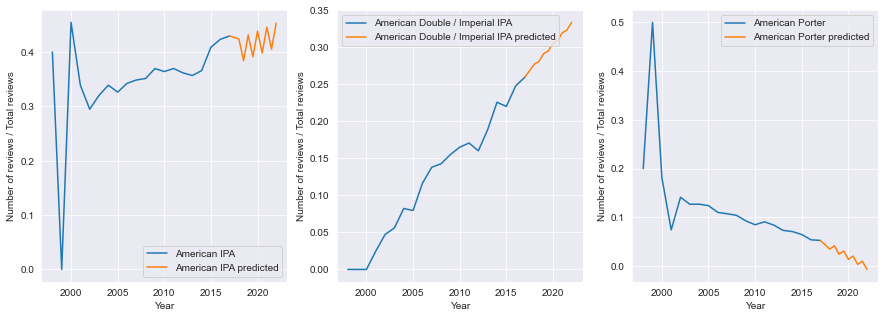

In [46]:
plot_style_style_frac_worldwide(style_top_3, year_list, True)

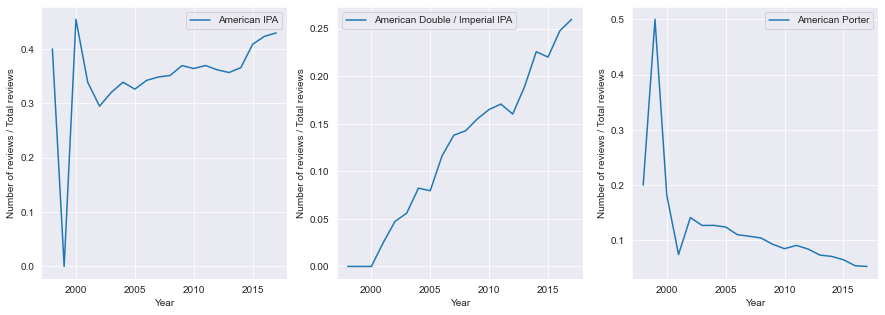

In [47]:
plot_style_style_frac_worldwide(style_top_3, year_list, False)

Now this can reveal the trend, we can learn that "American IPA" and "American Double/Imperial"" IPA's number of reviews are increasing worldwide, while that of "American Porter" is becoming less dominant.

**Next step: find and analyze the reasons behind the above trend.**
**_(May have a look at the trend of the number of positive, negative reviews of that styles in each year_**

Here, we may tell that the breweries should lay more emphasis on the production of beers of type "American IPA" and "American Double/Imperial IPA", while give less attention to the production of "American Porter" Beer.

After having a glimpse of the fraction of the 3 types of beers with the highest popularity, we need to dig deeper to find the trend of the style in different region.

In [48]:
df.columns

Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv',
       'date', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating',
       'nbr_ratings', 'nbr_reviews', 'location'],
      dtype='object')

In [49]:
# define the function to plot the top 5 regions that have reviews of one particular type
def plot_style_region(style=None, number_regions=5, data_frame=df):

    data = data_frame[data_frame['style'] == style]
    region_list = data[['location', 'beer_id']].groupby('location').agg('count')
    region_list.rename(columns={'beer_id': 'count'}, inplace=True)
    region_list = region_list.sort_values(by='count', ascending=False)
    region_list.reset_index(inplace=True)
    region_list = region_list.iloc[:number_regions]['location'].to_list()
    # print(region_list)
    fraction_dict_top_regions = {}
    if number_regions <= 5:
        fig, ax = plt.subplots(1, number_regions, figsize = (60, 5))
    else:
        fig, ax = plt.subplots(number_regions//5, 5, figsize = (60, 80))
    for location in region_list:
        fraction_dict_top_regions[location] = []
        for year in year_list:
            temp = data_frame[data_frame['date']==year]
            num_reviews_region_year = len(temp[temp['location']==location])
            temp2 = data[data['date']==year]
            if num_reviews_region_year == 0:
                frac_reviews_style_region_year = 0
            else:
                frac_reviews_style_region_year = len(temp2[temp2['location']==location]) / num_reviews_region_year
            fraction_dict_top_regions[location].append(frac_reviews_style_region_year)
    for idx, key in enumerate(fraction_dict_top_regions.keys()):
        count = pd.DataFrame(fraction_dict_top_regions[key], year_list)
        if number_regions > 5:
            sns.lineplot(x=count.index.astype(str), y=count[0], data=count, ax = ax[math.floor(idx//5), idx%5], legend=True, label= key, palette='rainbow')
            ax[math.floor(idx//5), idx%5].legend(prop={'size': 20})
            ax[math.floor(idx//5), idx%5].set_ylabel('Number of reviews / Total reviews')
            ax[math.floor(idx//5), idx%5].set_xlabel('Year')
            ax[math.floor(idx//5), idx%5].set_title(key)
        else:
            sns.lineplot(x=count.index.astype(str), y=count[0], data=count, ax = ax[idx], legend=True, label= key, palette='rainbow')
            ax[idx].legend(prop={'size': 15})
            ax[idx].set_ylabel('Number of reviews / Total reviews')
            ax[idx].set_xlabel('Year')
        # ax[idx].set_xtick(count.index.values.astype(str), rotation=45)

        fig.suptitle(f'The fraction of reviews of {style} in top {number_regions} regions', fontsize=30)


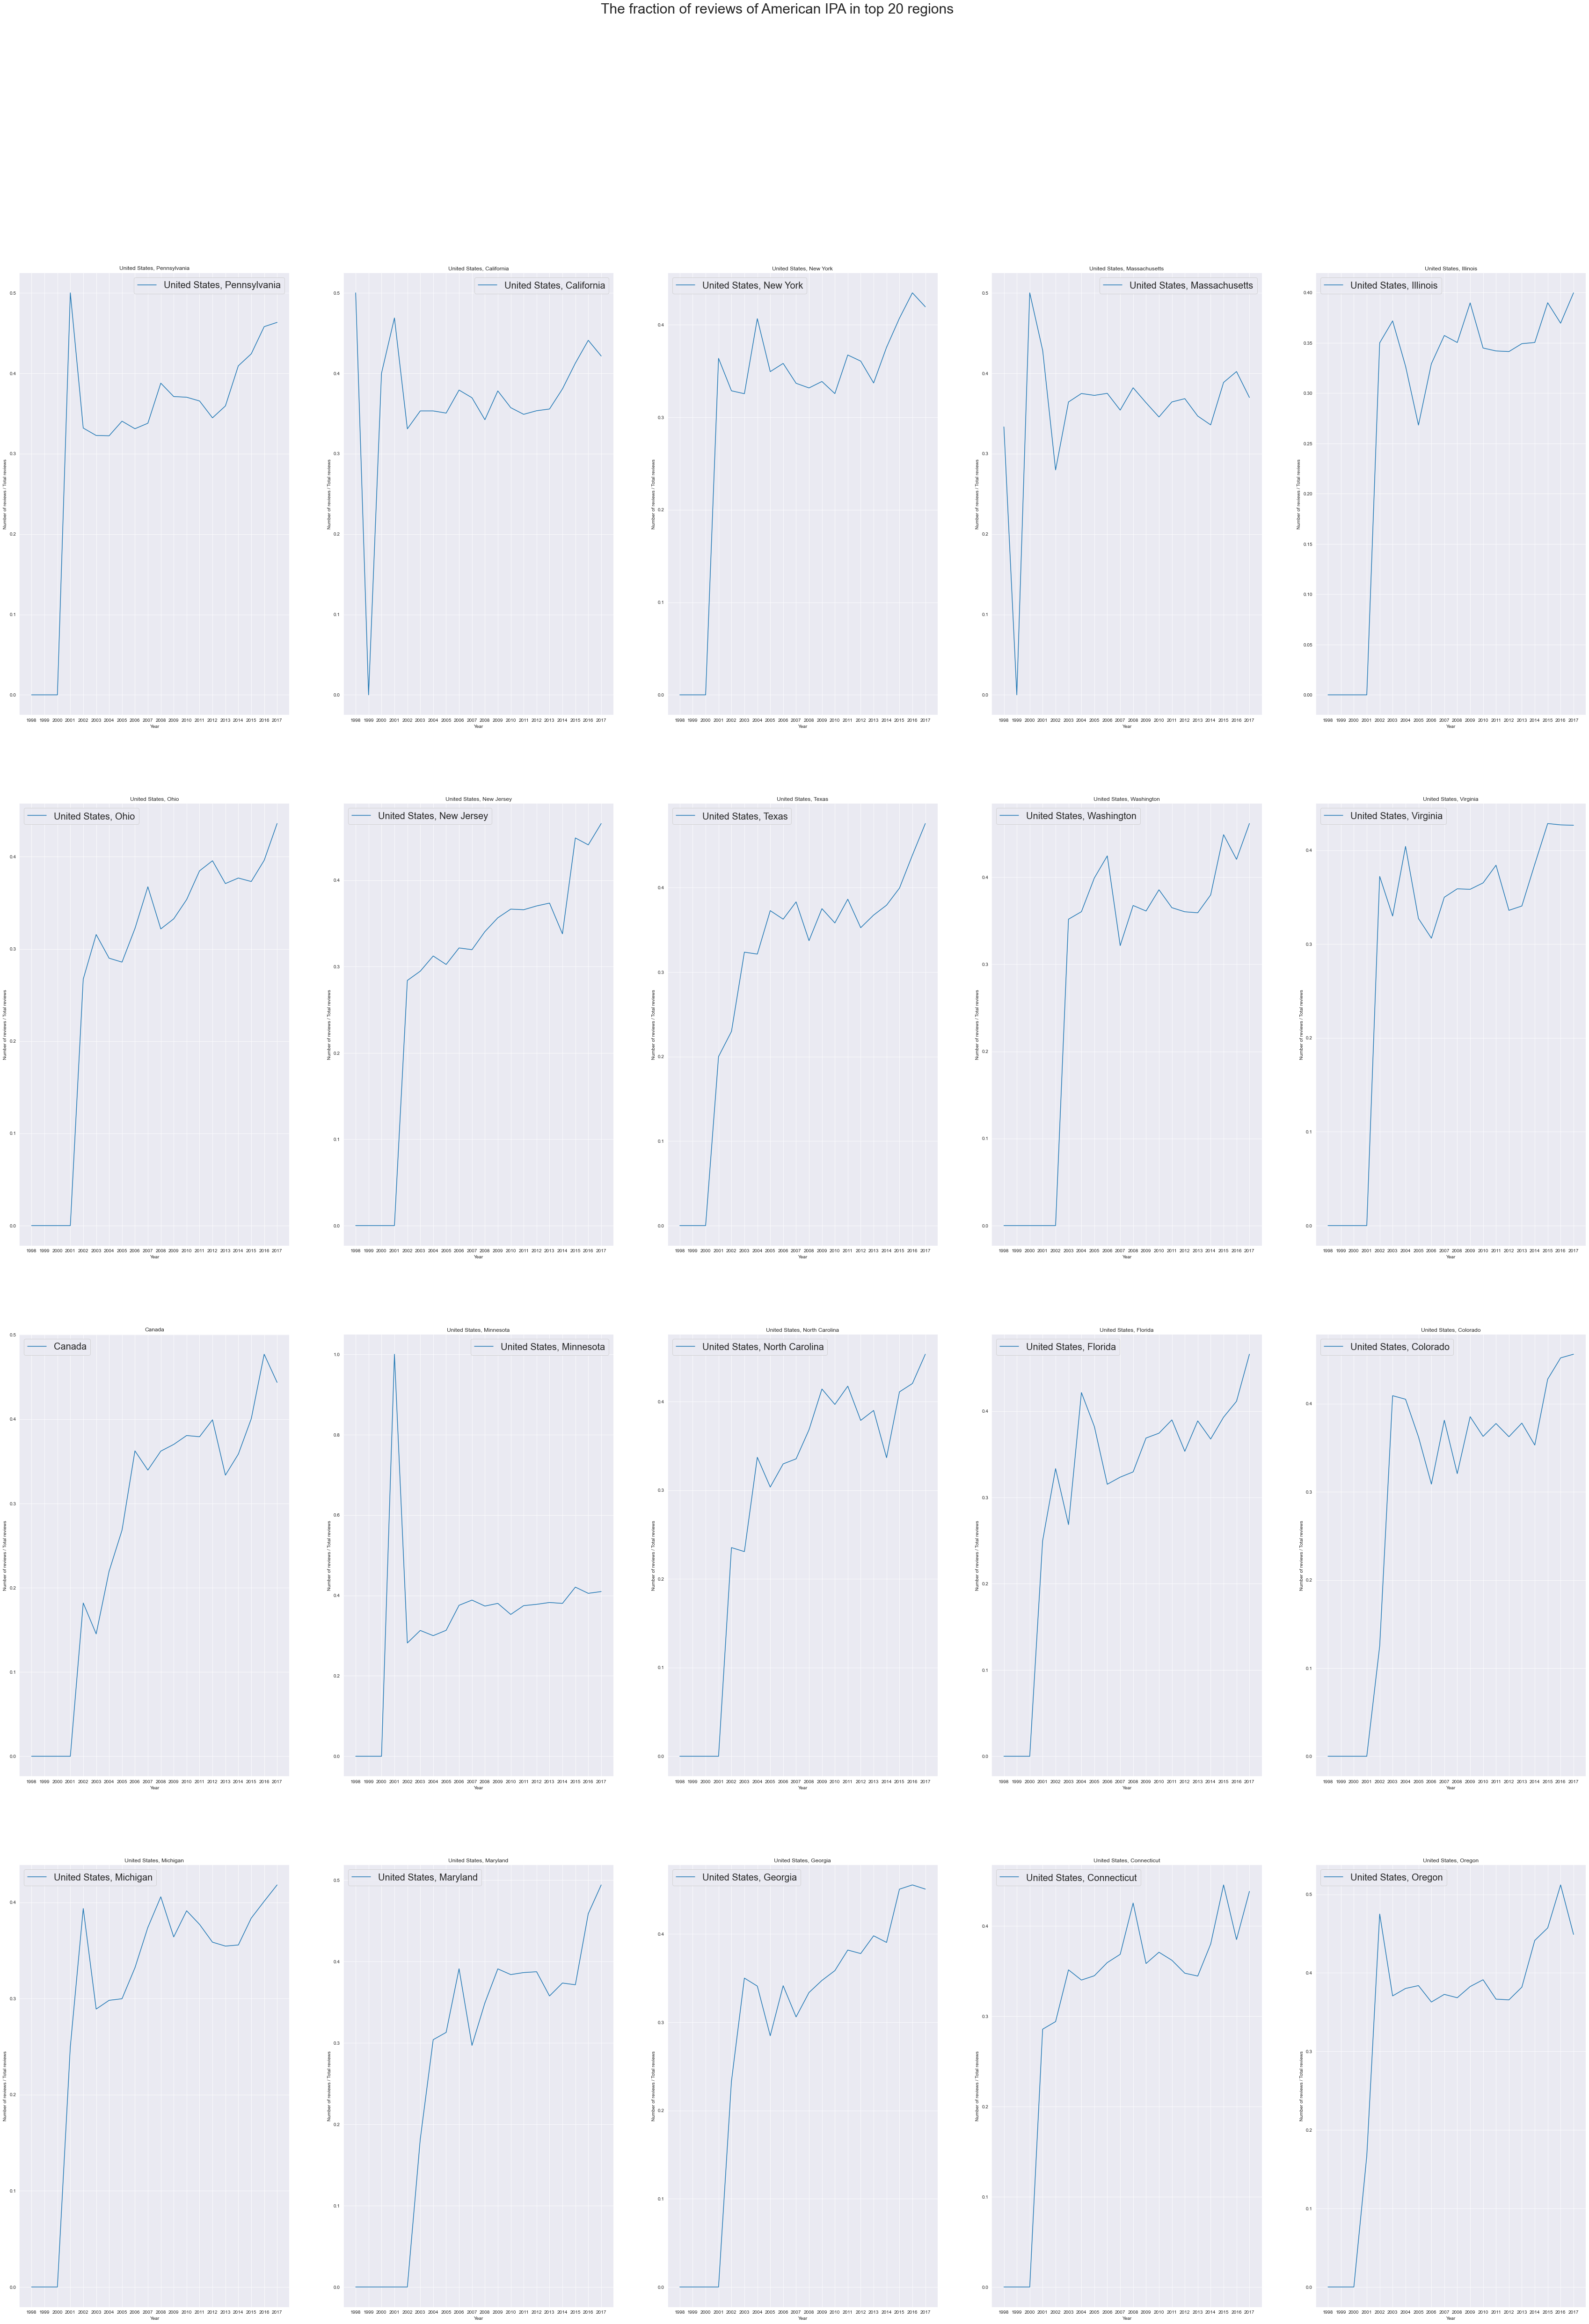

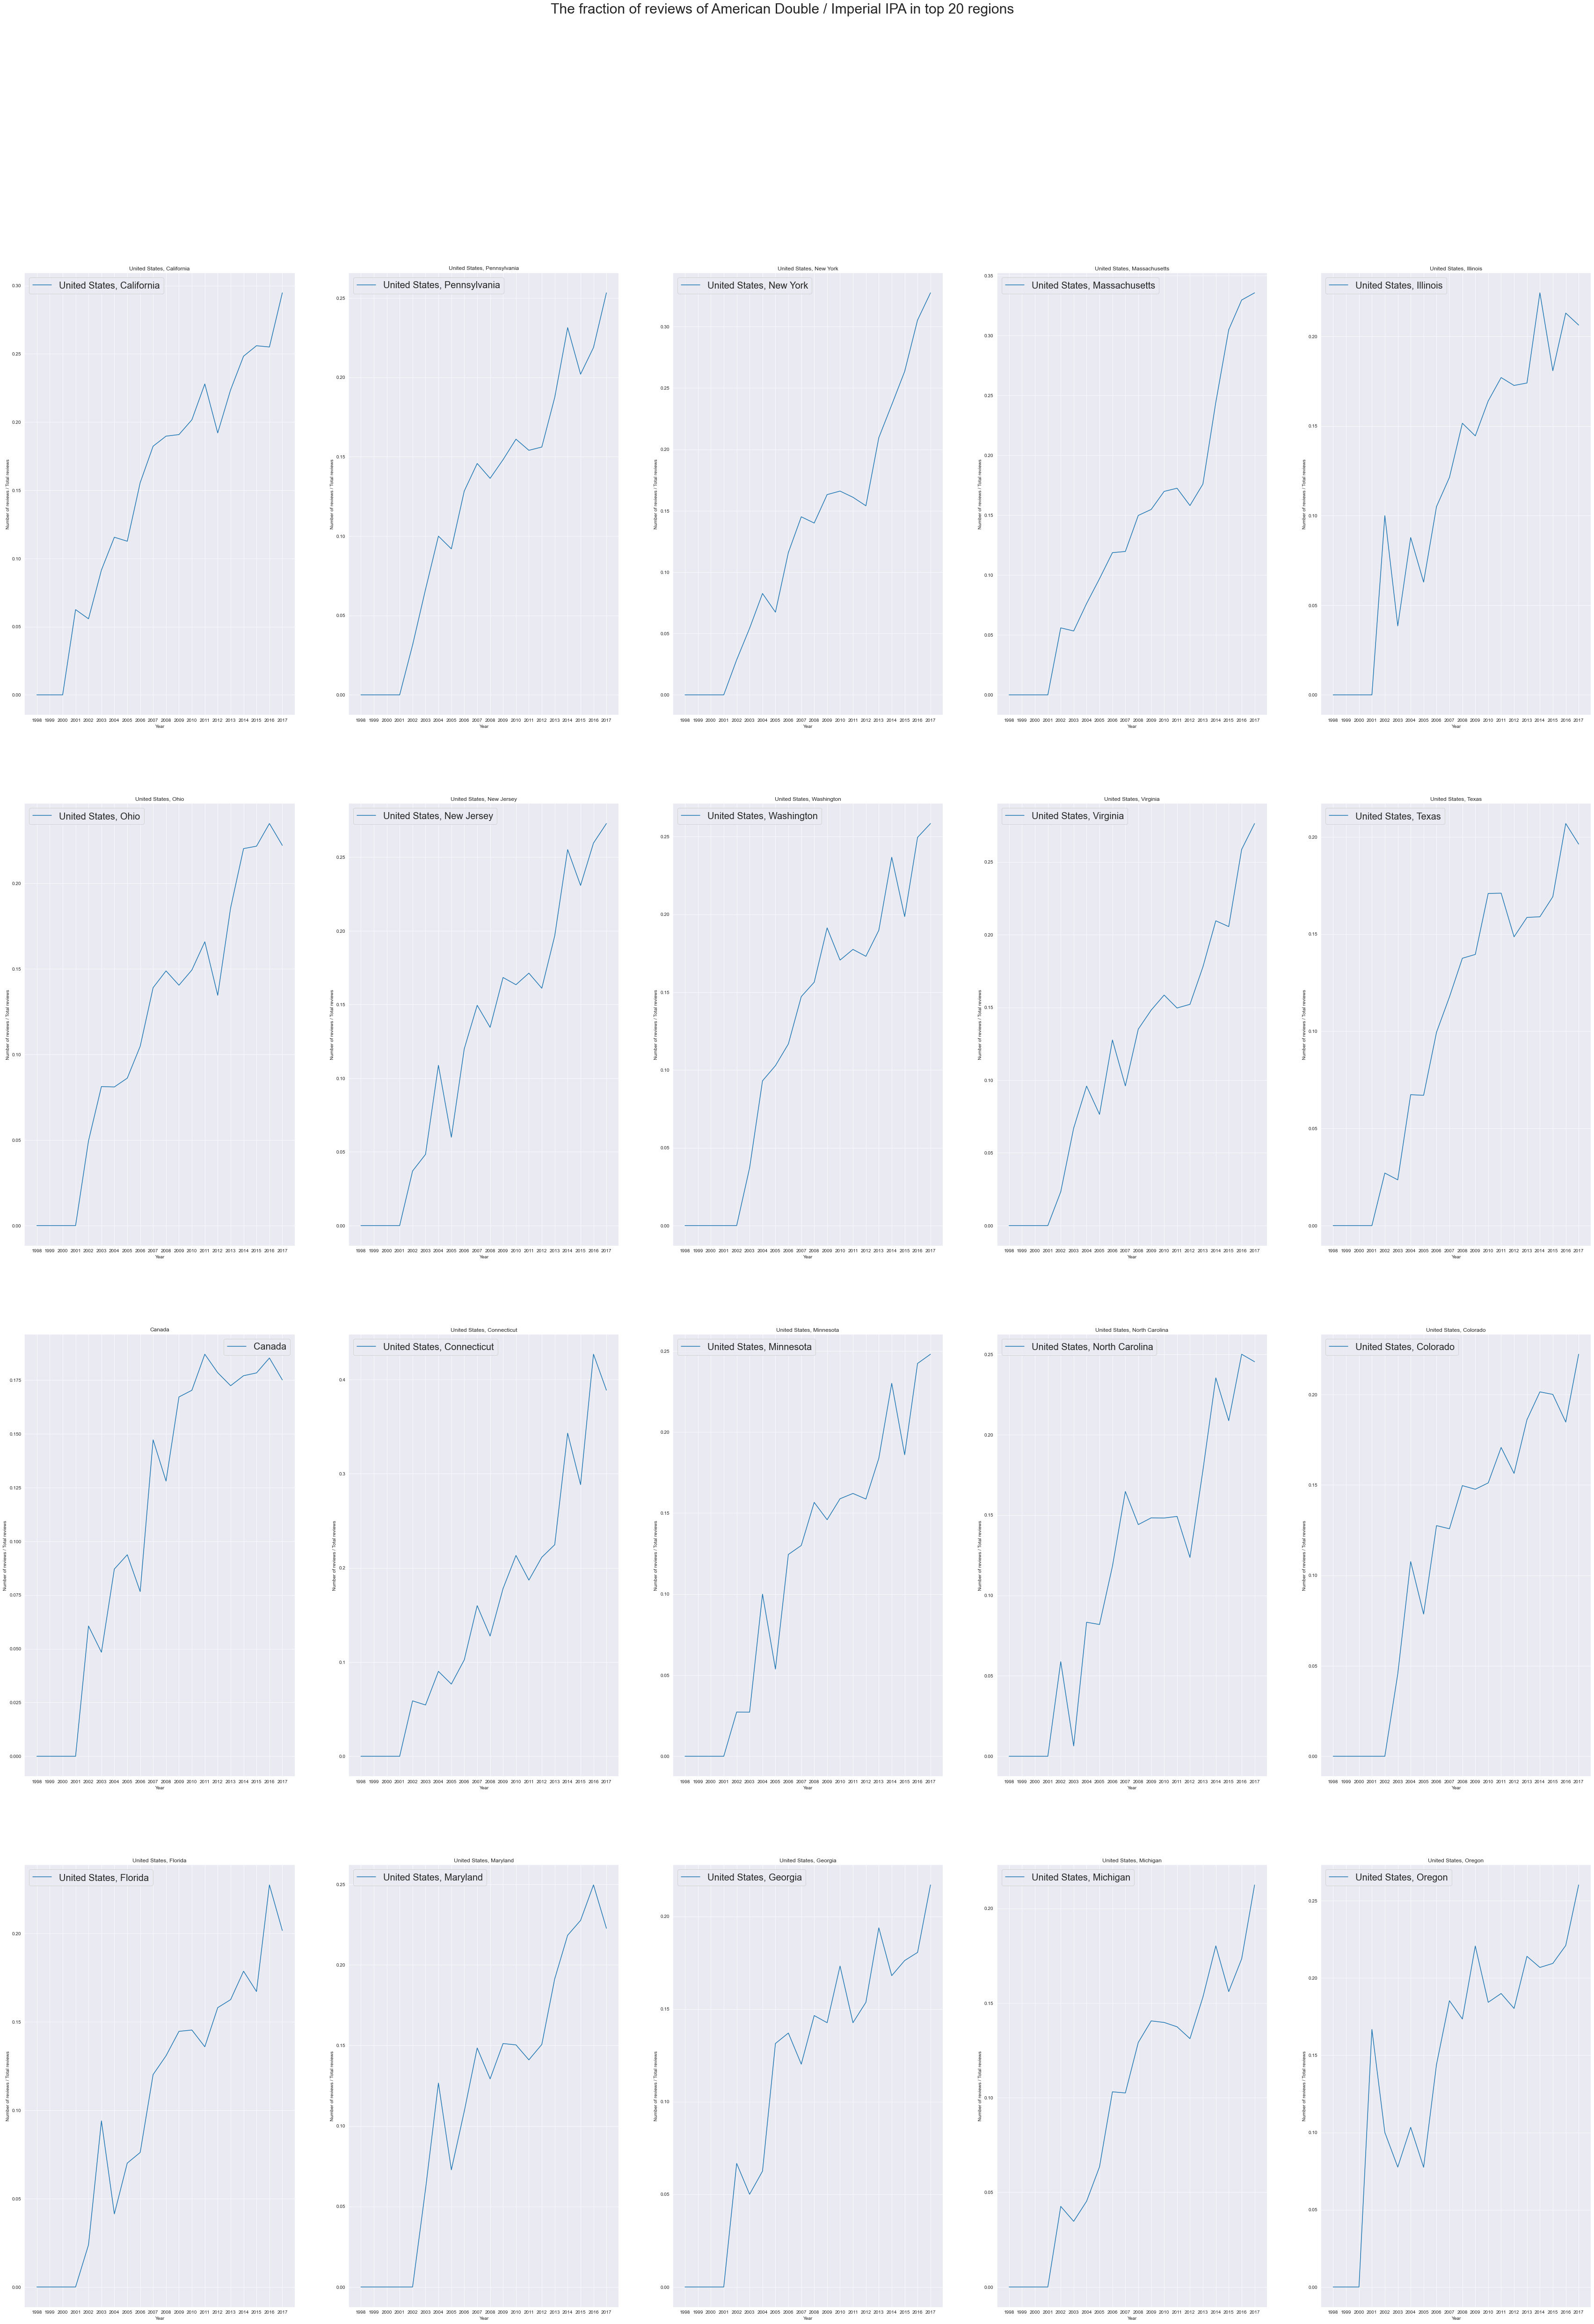

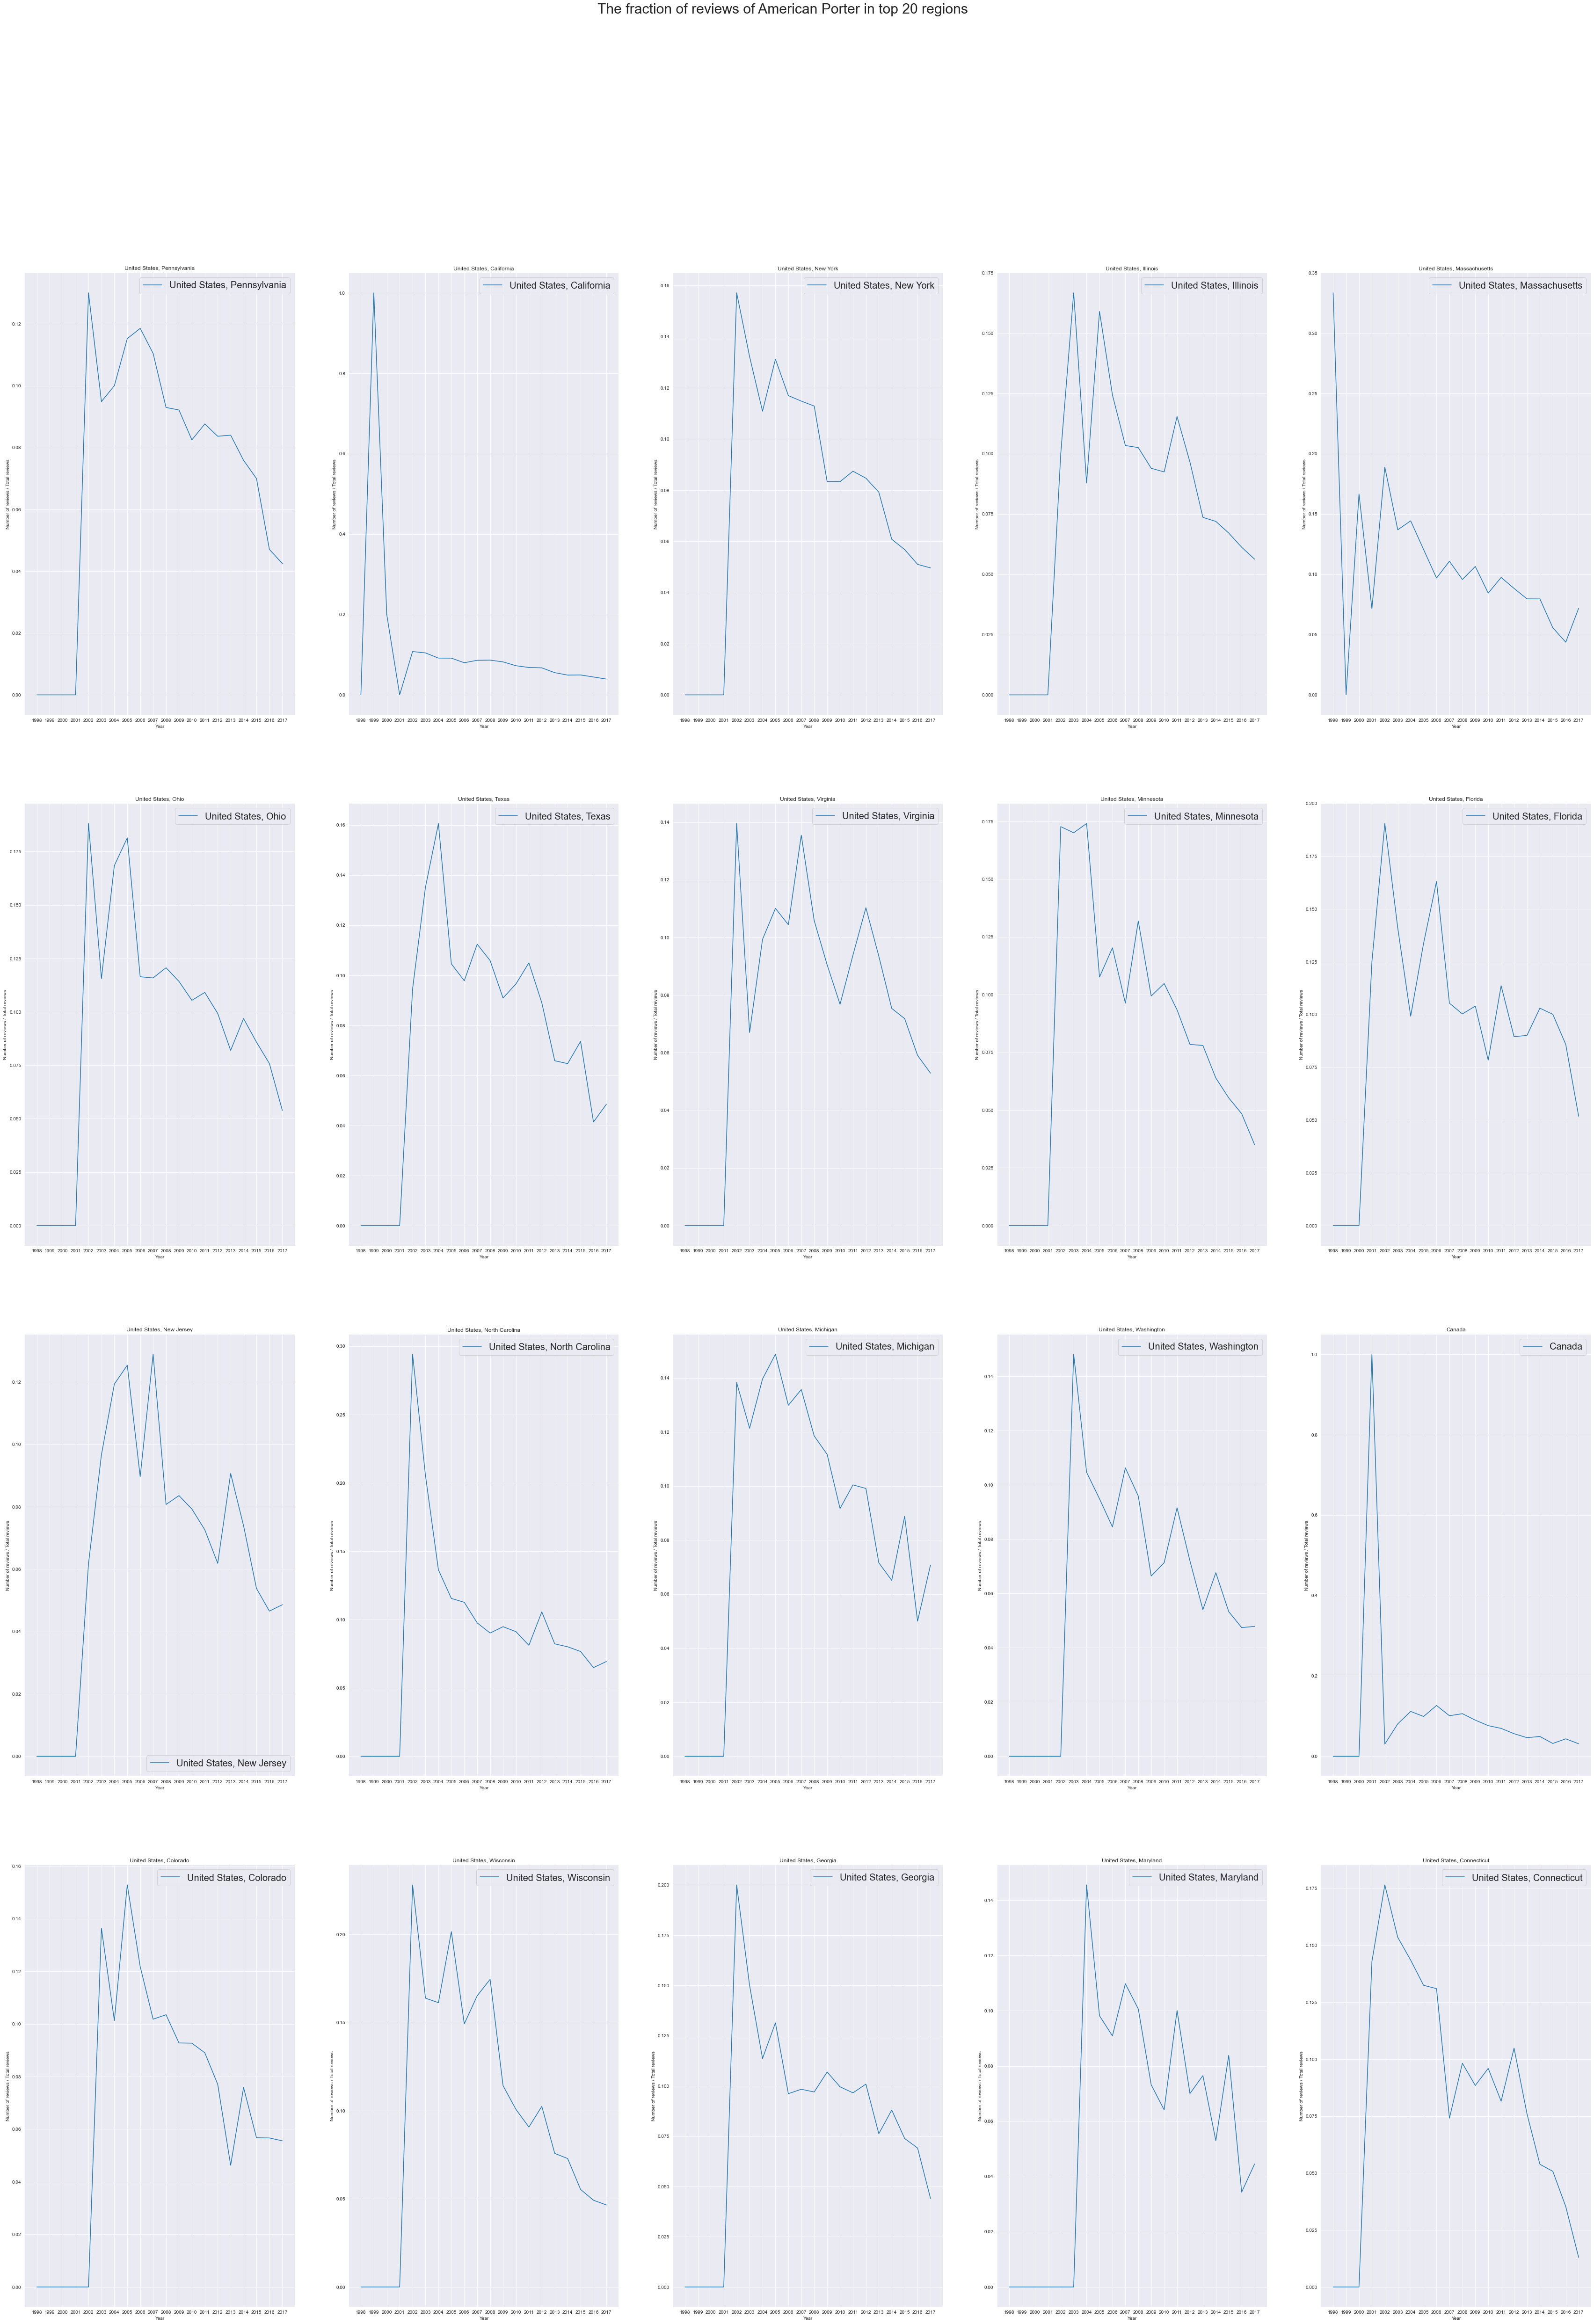

In [50]:
for style in style_top_3:
    plot_style_region(style, 20, df)

In [51]:
from bokeh.palettes import Dark2_5 as palette
import itertools


# define the function to plot the top 5 regions that have reviews of one particular type
def plot_style_region_bokeh(style=None, number_regions=5, data_frame=df):

    data = data_frame[data_frame['style'] == style]
    region_list = data[['location', 'beer_id']].groupby('location').agg('count')
    region_list.rename(columns={'beer_id': 'count'}, inplace=True)
    region_list = region_list.sort_values(by='count', ascending=False)
    region_list.reset_index(inplace=True)
    region_list = region_list.iloc[:number_regions]['location'].to_list()
    # print(region_list)
    fraction_dict_top_regions = {}

    p = figure(title=style)
    # create a color iterator
    colors = palette.__iter__()

    for location in region_list:
        fraction_dict_top_regions[location] = []
        for year in year_list:
            temp = data_frame[data_frame['date']==year]
            num_reviews_region_year = len(temp[temp['location']==location])
            temp2 = data[data['date']==year]
            if num_reviews_region_year == 0:
                frac_reviews_style_region_year = 0
            else:
                frac_reviews_style_region_year = len(temp2[temp2['location']==location]) / num_reviews_region_year
            fraction_dict_top_regions[location].append(frac_reviews_style_region_year)
    for idx, key in enumerate(fraction_dict_top_regions.keys()):
        count = pd.DataFrame(fraction_dict_top_regions[key], year_list)
        p.line(count.index, count[0], legend_label=region_list[idx], color=next(colors))
    p.legend.click_policy="mute"
    p.xaxis.axis_label = 'Year'
    p.yaxis.axis_label = 'Number of reviews / Total reviews'

    return p

In [52]:
p1 = plot_style_region_bokeh(style_top_3[0], 3, df)
p2 = plot_style_region_bokeh(style_top_3[1], 3, df)
p3 = plot_style_region_bokeh(style_top_3[2], 3, df)


In [53]:
from bokeh.layouts import column, gridplot
grid =  gridplot([[p1],[p2], [p3]], width=1000, height=300, toolbar_location=None)
show(grid)
# output_file('./figure/trend_in_region.html')

NEXT: **Give suggestions to breweries**

## Sentiment Analysis for BeerAdvocate reviews

In this part, we will analyze the sentiment of BeerAdvocate reviews in order to determine whether the positive / negative proportion in review is related to the trend of beer popularity.

In [54]:
analyzer = SentimentIntensityAnalyzer()
df_sentiment_ba = region_ba_filtered.copy()

# Because some text just in type of float, we need to convert it to string
df_sentiment_ba.text = df_sentiment_ba.text.astype(str)


In [55]:
# Get sentiment score for each review

positive_list, negative_list, neutral_list = [], [], []
pos, neg, neu, compound = [], [], [], []

for i in range(df_sentiment_ba.shape[0]):
    text = df_sentiment_ba.iloc[i]['text']
    vs = analyzer.polarity_scores(text)
    positive = 1 if vs['compound'] >= 0.5 else 0
    negative = 1 if vs['compound'] <= -0.5 else 0
    neutral = 1 if vs['compound'] > -0.5 and vs['compound'] < 0.5 else 0
    positive_list.append(positive)
    negative_list.append(negative)
    neutral_list.append(neutral)
    pos.append(vs['pos'])
    neg.append(vs['neg'])
    neu.append(vs['neu'])
    compound.append(vs['compound'])

df_sentiment_ba['positive'] = positive_list
df_sentiment_ba['negative'] = negative_list
df_sentiment_ba['neutral'] = neutral_list
df_sentiment_ba['pos'] = pos
df_sentiment_ba['neg'] = neg
df_sentiment_ba['neu'] = neu


In [56]:
# Change to datetime
df_sentiment_ba['date'] = df_sentiment_ba.date.apply(lambda x: datetime.datetime.fromtimestamp(x).year)


### Fine the fraction of negative reviews in ['American IPA', 'American Double / Imperial IPA', 'American Porter']

In [57]:
style_name = ['American IPA', 'American Double / Imperial IPA', 'American Porter']

df_sentiment_ba_topStyle = pd.DataFrame(columns=['year', 'style', 'fraction_negative'])

for style in style_name:
    tmp = df_sentiment_ba[df_sentiment_ba['style'] == style]
    tmp_neg_nums = tmp[['date', 'negative']].groupby('date').agg('sum')['negative']
    tmp_nums = tmp[['date', 'beer_id']].groupby('date').agg('count')['beer_id']
    tmp = (tmp_neg_nums / tmp_nums).reset_index()
    tmp.columns = ['year', 'fraction_negative']
    tmp['style'] = style
    df_sentiment_ba_topStyle = pd.concat([df_sentiment_ba_topStyle, tmp])

ValueError: cannot reindex on an axis with duplicate labels

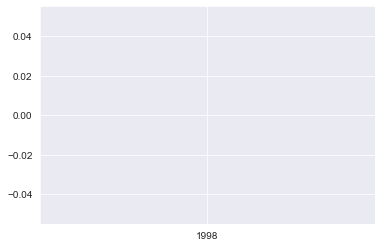

In [58]:
df_sentiment_ba_topStyle['year'] = df_sentiment_ba_topStyle['year'].astype(str)

sns.lineplot(data=df_sentiment_ba_topStyle, x='year', y='fraction_negative', hue='style')
plt.title('Fraction of negative reviews in top 3 styles')
plt.ylabel('Fraction of negative reviews')
plt.xticks(rotation=45)
plt.show()

The figure above is similar to the trend of the number of reviews over time.

### Builde a linear regression model to predict the rating based on the sentiment score

In [ ]:

mod = smf.ols(formula="overall ~ neg * neu * pos", data=df_sentiment_ba)
result = mod.fit()
print('RatingBeer Sentiment Analysis')
result.summary()

We could notice that the R-Squared is too low, which means the sentiment score is not a good predictor for the rating.

### Find the most frequent ADJ word in the negative review text

In [ ]:
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 15000000
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

df_negative_review = df_sentiment_ba.copy()
df_negative_review = df_negative_review[df_negative_review['negative'] == 1]
text = ''.join(df_negative_review['text'])


def Find_Frequent_Words(text):
    doc = nlp(text)
    doc = [token for token in doc if token.is_stop != True and token.is_punct != True]
    text = [token.lemma_ for token in doc if token.pos_ == 'ADJ']
    text = pd.Series(text)
    text = text.value_counts()
    text = pd.DataFrame(text)
    text = text.reset_index()
    text.columns = ['word', 'count']
    text = text.sort_values(by='count', ascending=False)
    text = text.reset_index(drop=True)
    return text



In [ ]:
frequent_adj_word = Find_Frequent_Words(text)

sns.barplot(x='count', y='word', data=frequent_adj_word.head(20))
plt.title('Top 20 frequent ADJ words in negative review')
plt.show()

We wanted to know the adjectives that appear most often in negative reviews and that contain what consumers are not satisfied with about these beers. The brewery can use these words to improve their beers.

### For each brewery, find the most frequent ADJ word

In [ ]:
most_popular_brewery = list(region_ba_filtered['brewery_name'].value_counts().index[:5])

In [ ]:
most_popular_brewery

In [ ]:
df_sentiment_ba_brewery = df_sentiment_ba[df_sentiment_ba['brewery_name'] == most_popular_brewery[0]]

In [ ]:
df_negative_review = df_sentiment_ba_brewery[df_sentiment_ba_brewery['negative'] == 1]
text = ''.join(df_negative_review['text'])

frequent_adj_word = Find_Frequent_Words(text)
sns.barplot(x='count', y='word', data=frequent_adj_word.head(20))
plt.title(f'Top 20 frequent ADJ words in {most_popular_brewery[0]} ')
plt.show()

User portrait

In [51]:
region_ba_style_change = region_ba_filtered.copy()

In [52]:
region_ba_style_change.date = region_ba_style_change.date.apply(lambda x: datetime.datetime.fromtimestamp(x).year)

In [53]:
temp_dict = region_ba_style_change.groupby('beer_id')['rating'].agg('mean').to_dict()

In [54]:
region_ba_style_change['avg_rating'] = region_ba_style_change['beer_id'].apply(lambda x:temp_dict[x])

In [55]:
region_ba_style_change['preference'] = region_ba_style_change.avg_rating * region_ba_style_change.nbr_ratings

In [56]:
from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
# %matplotlib qt

In [57]:
region_ba_style_change

beer_name  beer_id  \
10373    Belhaven Twisted Thistle IPA    25989   
10374    Belhaven Twisted Thistle IPA    25989   
10375    Belhaven Twisted Thistle IPA    25989   
10376    Belhaven Twisted Thistle IPA    25989   
10377    Belhaven Twisted Thistle IPA    25989   
...                               ...      ...   
1855894               Moving Parts 01   116858   
1855895               Moving Parts 01   116858   
1855896               Moving Parts 01   116858   
1855897               Moving Parts 01   116858   
1855898               Moving Parts 01   116858   

                                  brewery_name  brewery_id         style  abv  \
10373            Belhaven Brewery Company Ltd.         148  American IPA  6.1   
10374            Belhaven Brewery Company Ltd.         148  American IPA  6.1   
10375            Belhaven Brewery Company Ltd.         148  American IPA  6.1   
10376            Belhaven Brewery Company Ltd.         148  American IPA  6.1   
10377            Belhaven Brewery Company Ltd.         148  American IPA  6.1   
...                                        ...         ...           ...  ...   
1855894  Victory Brewing Company - Downingtown         345  American IPA  7.1   
1855895  Victory Brewing Company - Downingtown         345  American IPA  7.1   
1855896  Victory Brewing Company - Downingtown         345  American IPA  7.1   
1855897  Victory Brewing Company - Downingtown         345  American IPA  7.1   
1855898  Victory Brewing Company - Downingtown         345  American IPA  7.1   

         date   user_name_x  user_id  appearance  ...  rating  \
10373    2017         djura   544616      3.1250  ...  3.5375   
10374    2017         MJSFS   977888      3.4375  ...  2.6875   
10375    2017        Buck89   940400      3.7500  ...  3.4625   
10376    2017  Czequershuus   780649      3.4375  ...  3.6875   
10377    2016      Gardendk  1185249      2.5000  ...  2.8000   
...       ...           ...      ...         ...  ...     ...   
1855894  2014   BEERchitect    14442      3.4375  ...  3.4375   
1855895  2014      larryi86   445106      3.7500  ...  3.9375   
1855896  2014       barczar   397246      3.7500  ...  3.2750   
1855897  2014       Jadjunk   401113      3.7500  ...  3.3875   
1855898  2014    RblWthACoz    93332      3.7500  ...  3.4625   

                                                      text  review  \
10373    Found it here in Serbia, bottle 0,33 lA - Pale...    True   
10374    Bubbly sugary urine water. I'm confused how an...    True   
10375    Poured from a tap into a pint glass. A clear a...    True   
10376    This beer pours pale amber with an average hea...    True   
10377                                                    A    True   
...                                                    ...     ...   
1855894  Though their heart is in European traditions, ...    True   
1855895  22 oz bottle poured into a snifterA- A clear g...    True   
1855896  Pours a brilliant golden with a billowing crea...    True   
1855897  &quot;We like to mix it up. New flavors, new i...    True   
1855898  Best by 11/6/14. This definitely seems past it...    True   

         nbr_ratings  nbr_reviews   user_name_y        joined  \
10373            421          368         djura  1.293534e+09   
10374            742          205         MJSFS           NaN   
10375           1112          832        Buck89  1.423307e+09   
10376           1011          800  Czequershuus  1.391771e+09   
10377             10           10      Gardendk  1.482664e+09   
...              ...          ...           ...           ...   
1855894         6778         6778   BEERchitect  1.107947e+09   
1855895         1311         1232      larryi86  1.270375e+09   
1855896         2713         2682       barczar  1.259233e+09   
1855897         1175         1175       Jadjunk  1.260097e+09   
1855898         3905         3450    RblWthACoz  1.155982e+09   

                            location  avg_rating   

In [60]:
def plot_interactive(region, year, ax):
    data_to_plot = region_ba_style_change[(region_ba_style_change.location==region)][['brewery_name', 'style','preference']]
    data_to_plot = region_ba_style_change[(region_ba_style_change.date==year)]
    # print(len(data_to_plot))
    # data_to_plot['preference'] = data_to_plot.overall * data_to_plot.nbr_ratings
    data_to_plot = data_to_plot.groupby('style').mean().reset_index()
    data_to_plot = data_to_plot.sort_values('preference', ascending=False).head(10)
    if len(data_to_plot) > 0:
        sns.barplot(y='style', x='preference', data=data_to_plot, palette="magma",ax=ax)
        plt.title(f'10 beer styles in {region} that are the most popular in year {year}.')
        ax.set_ylabel('Beer style')
        ax.set_xlabel('Overall score')
    # else:
    #     popup(f"Insufficient data for {region} in {year}.")


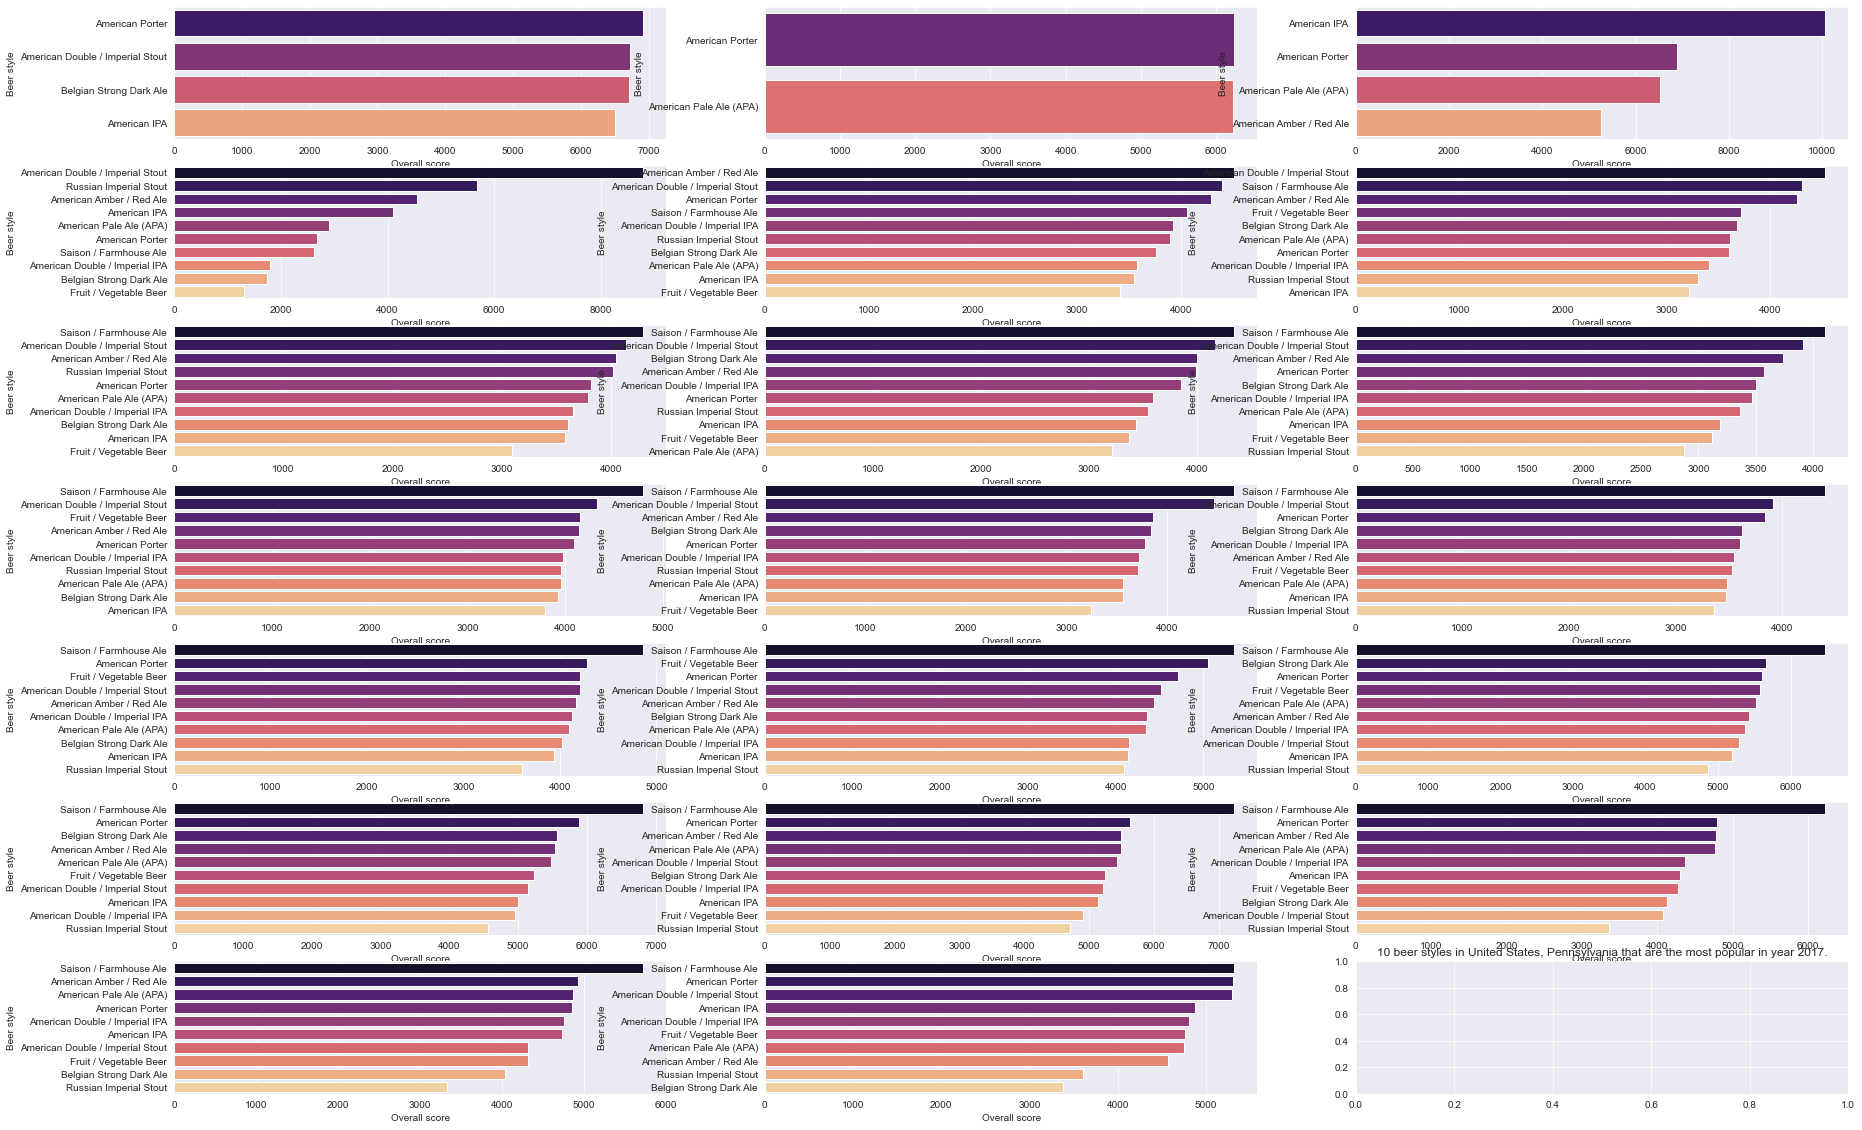

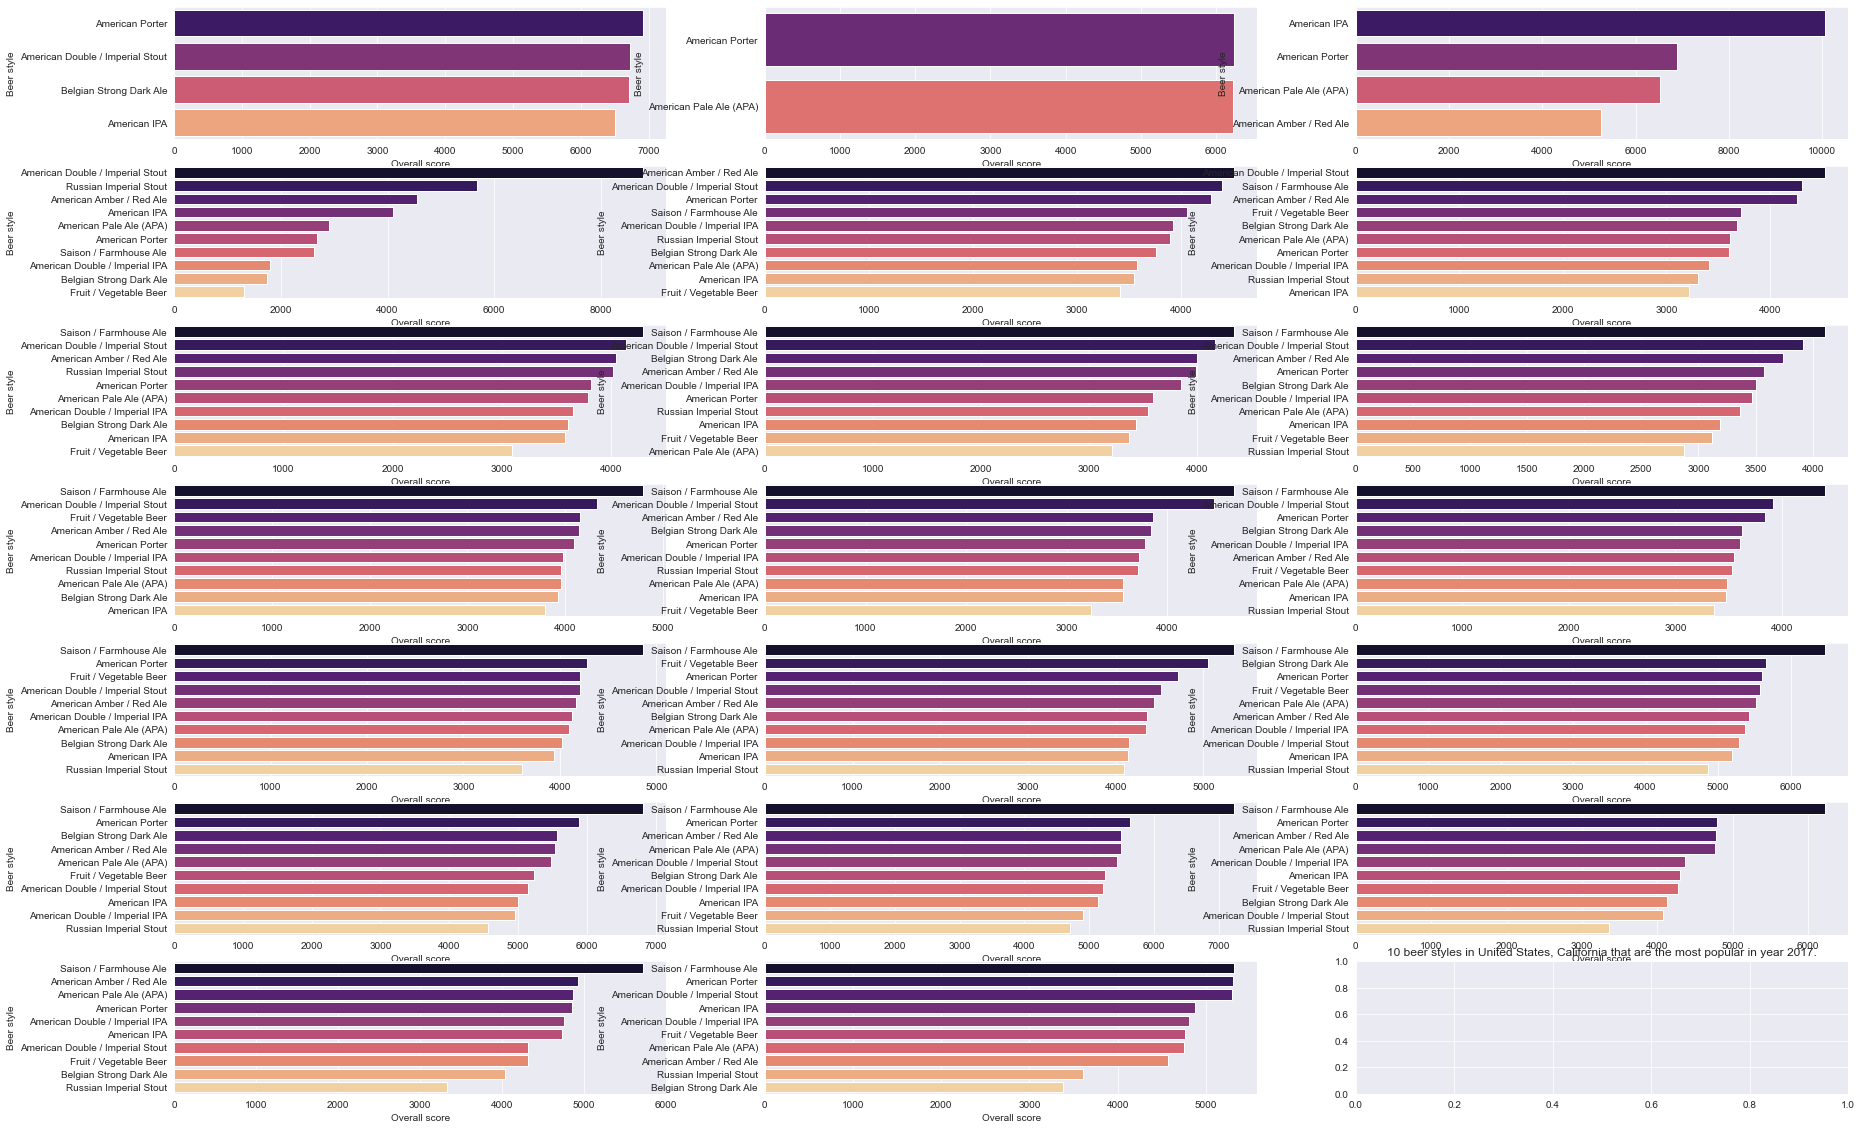

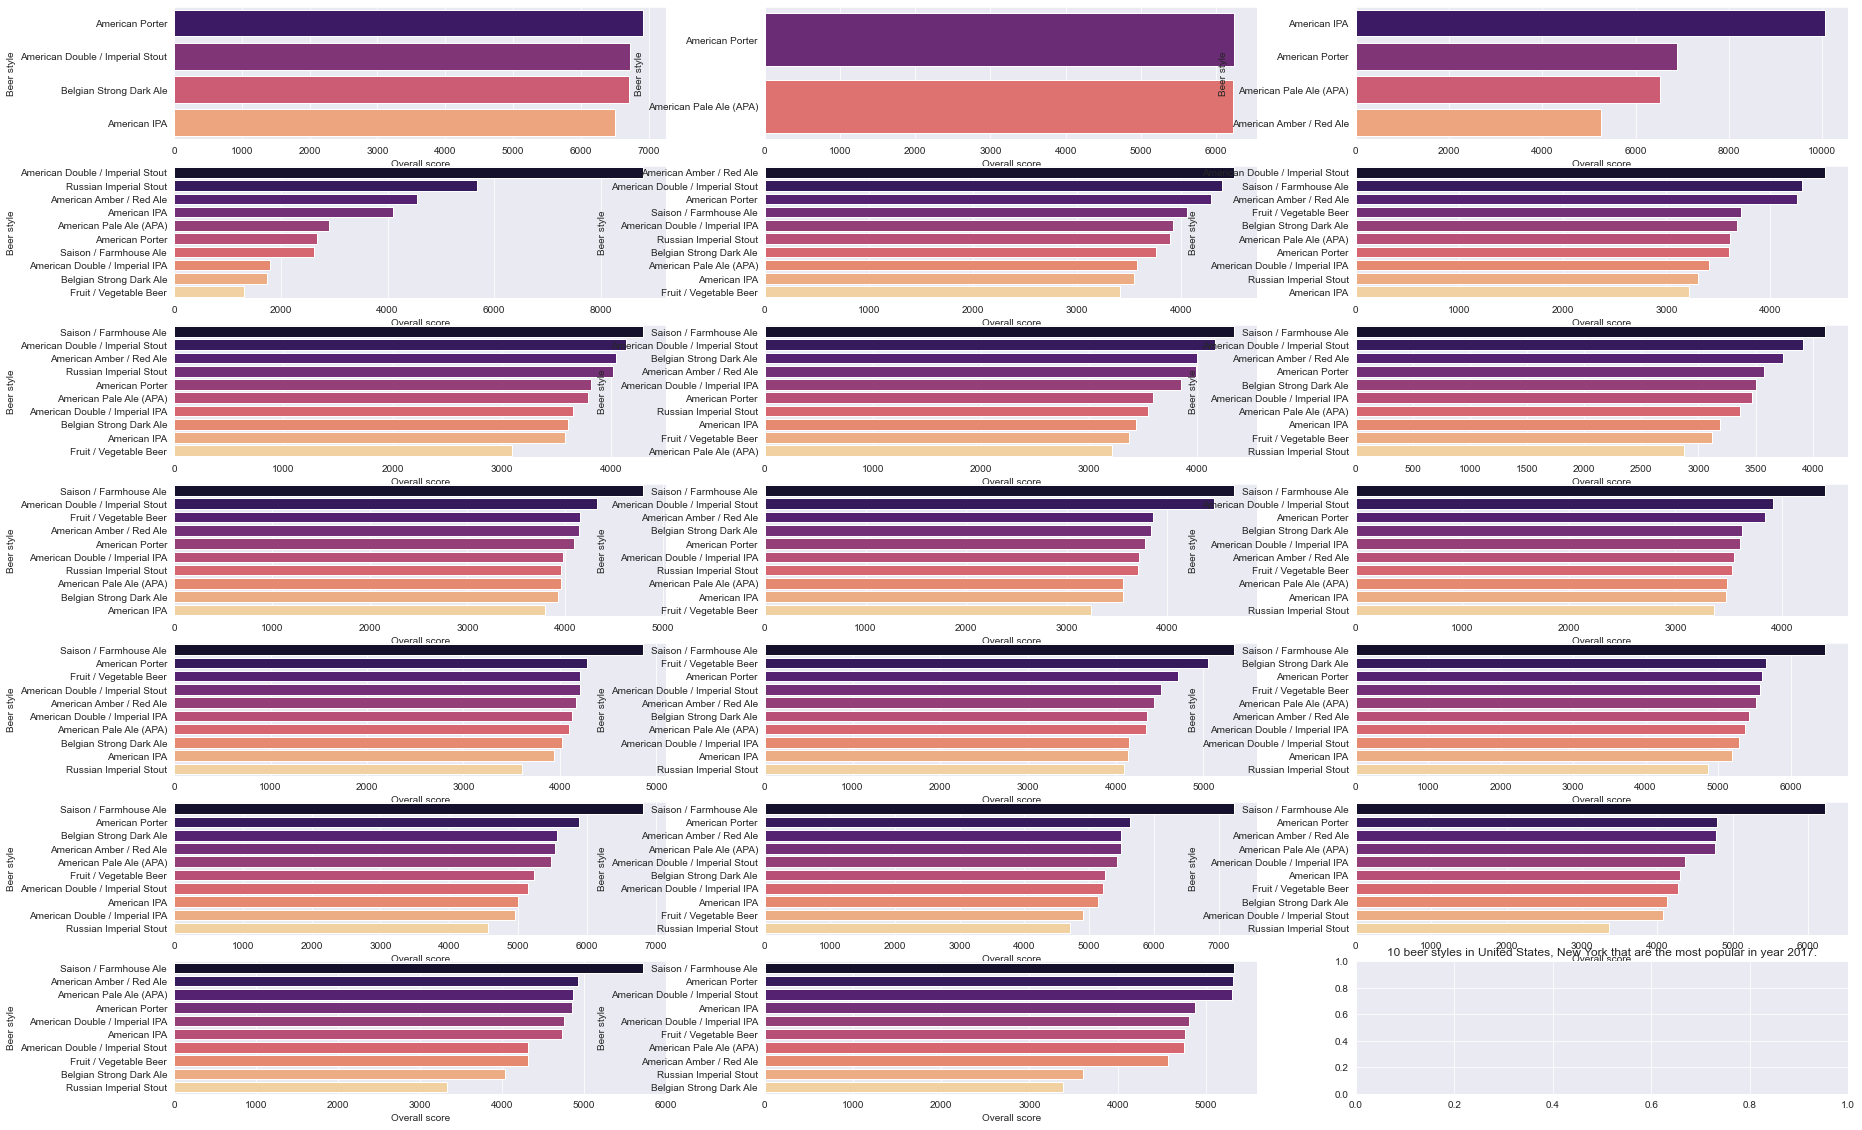

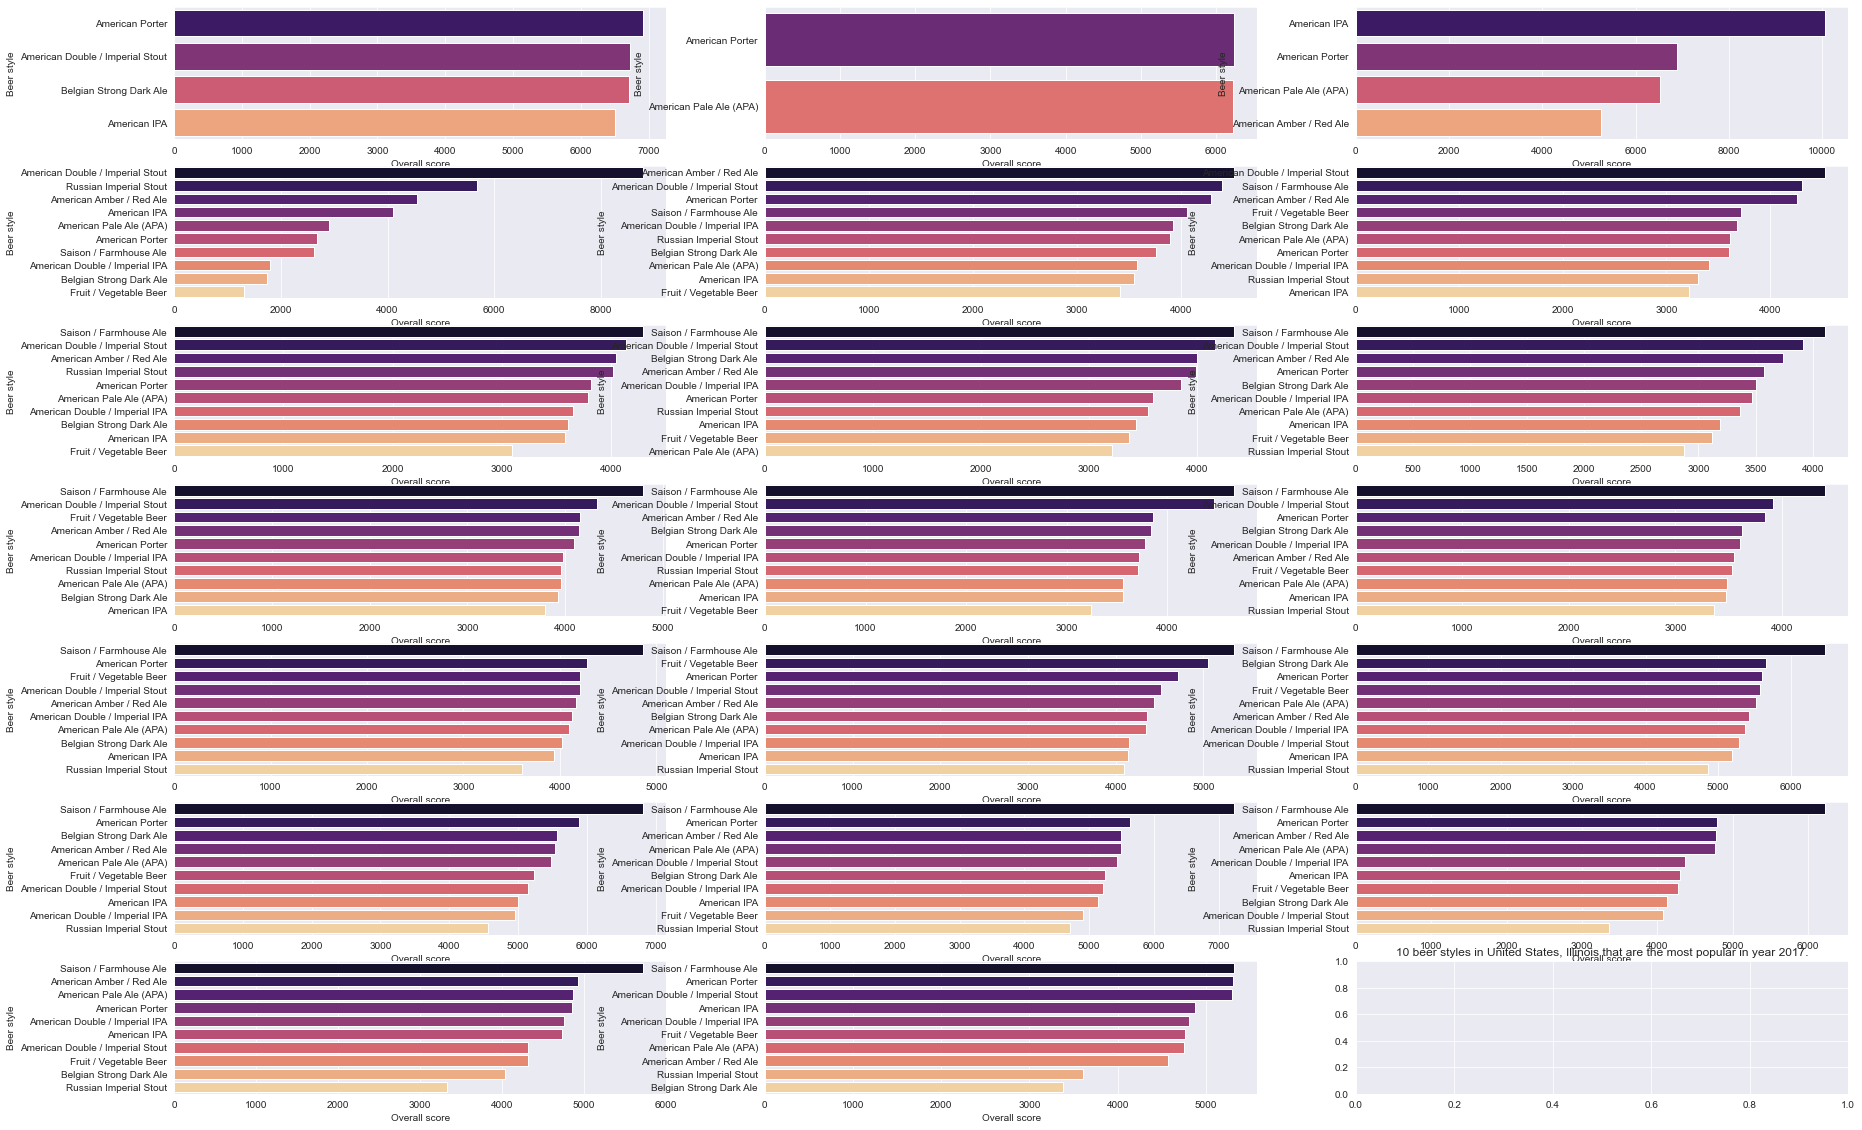

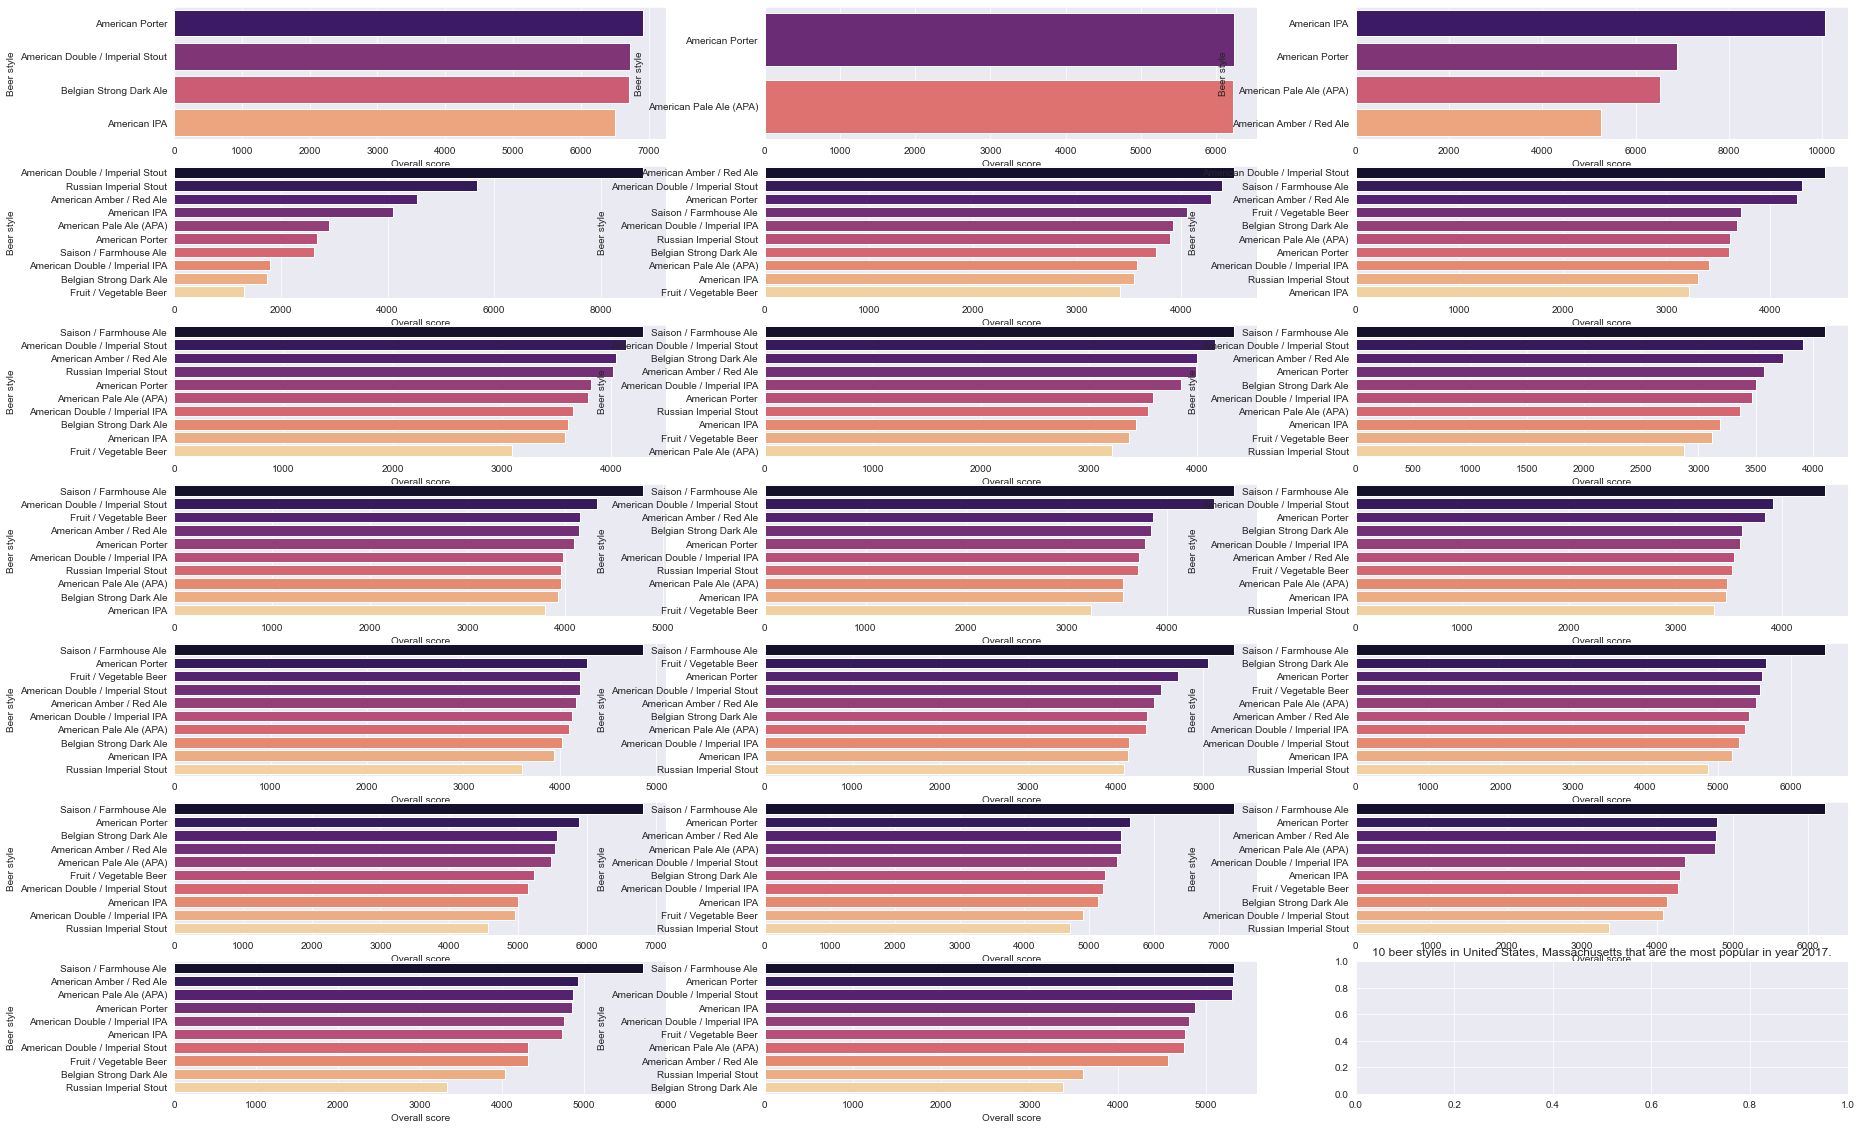

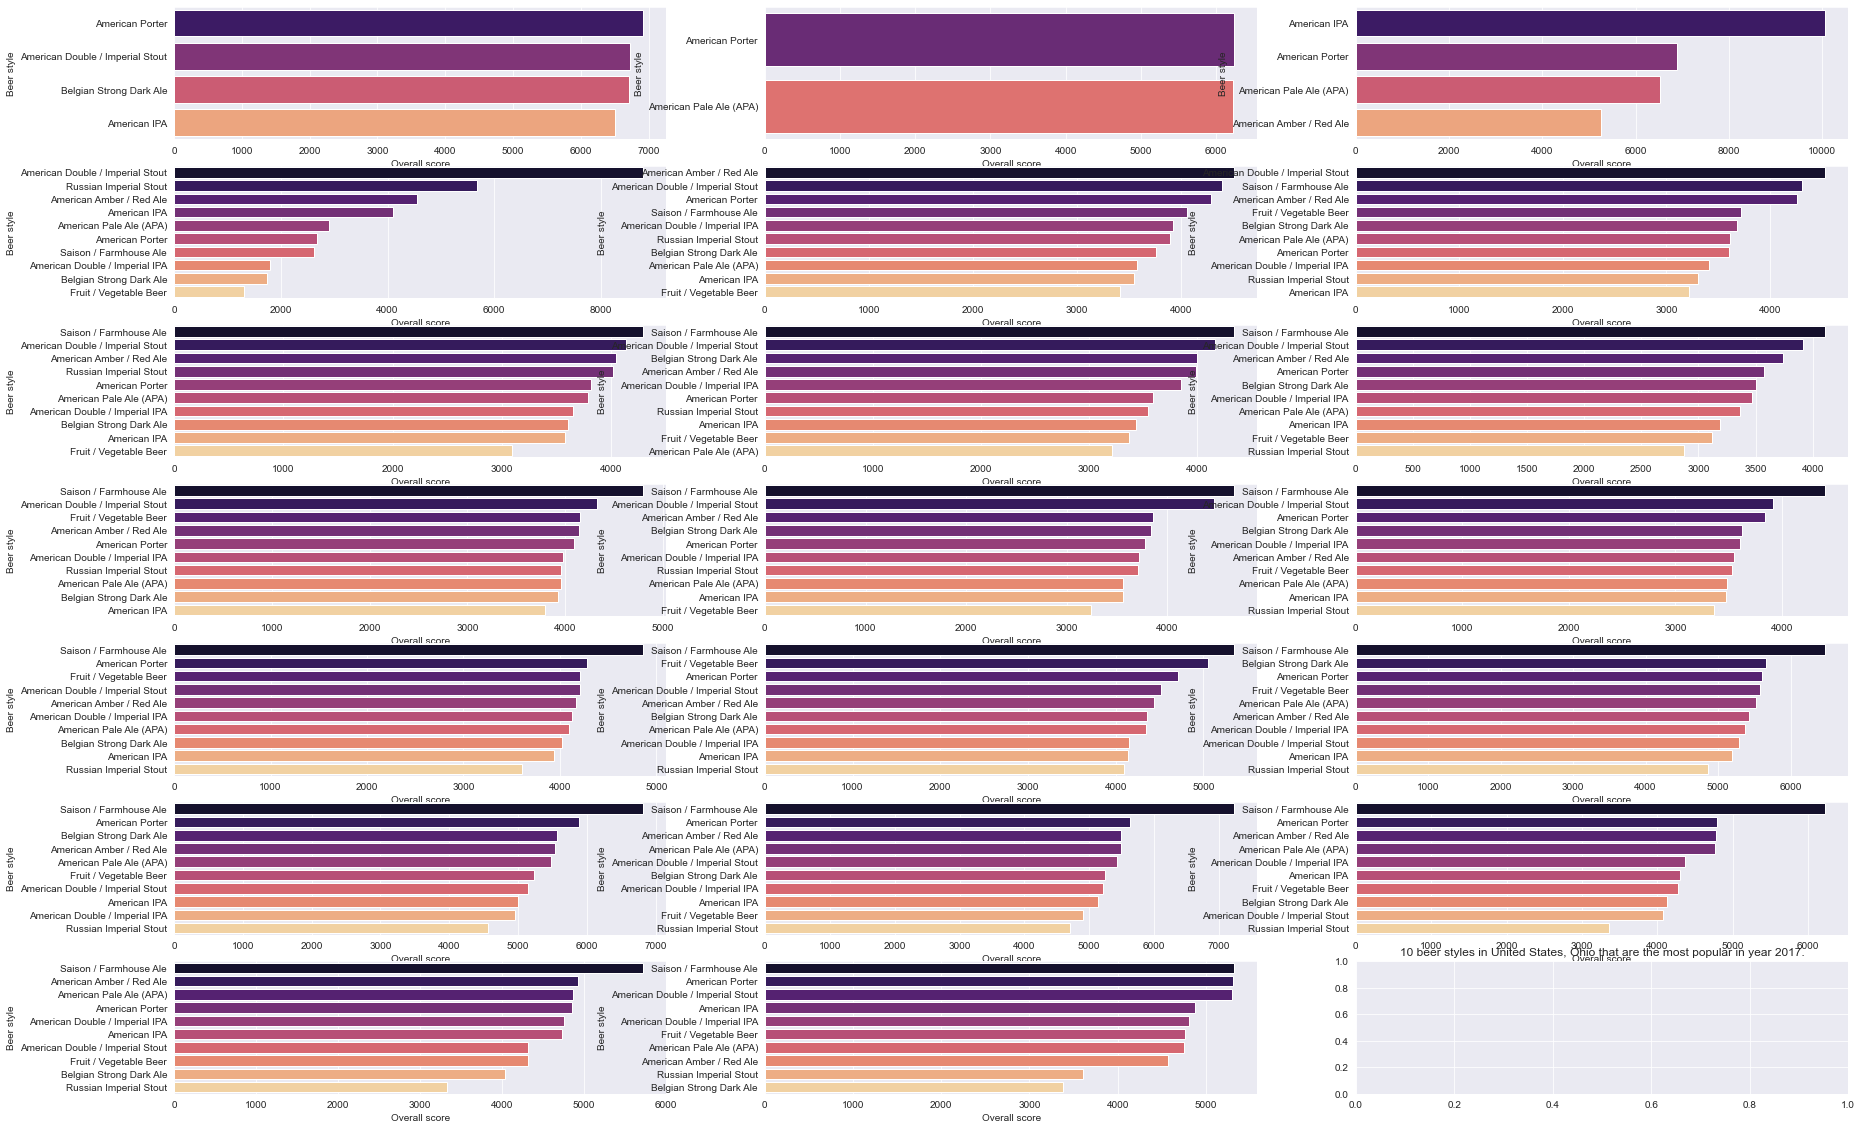

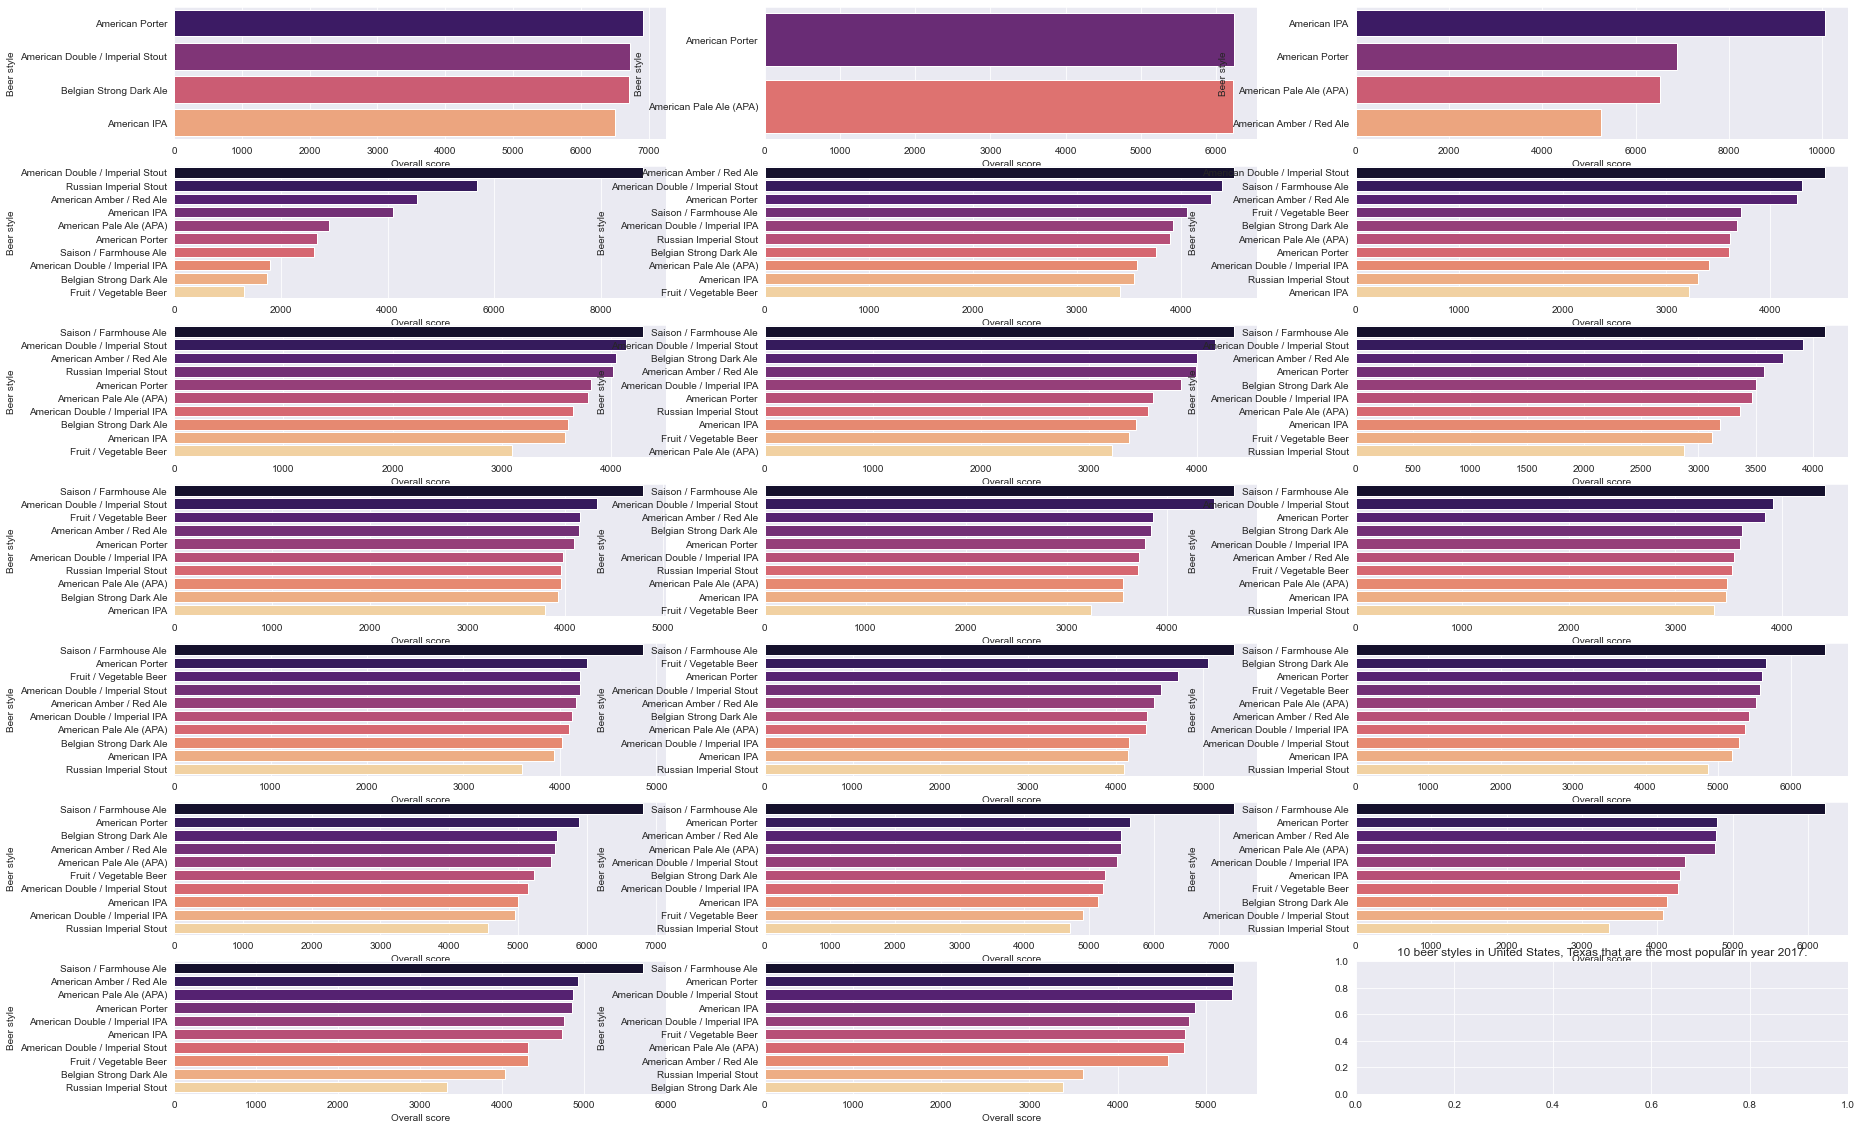

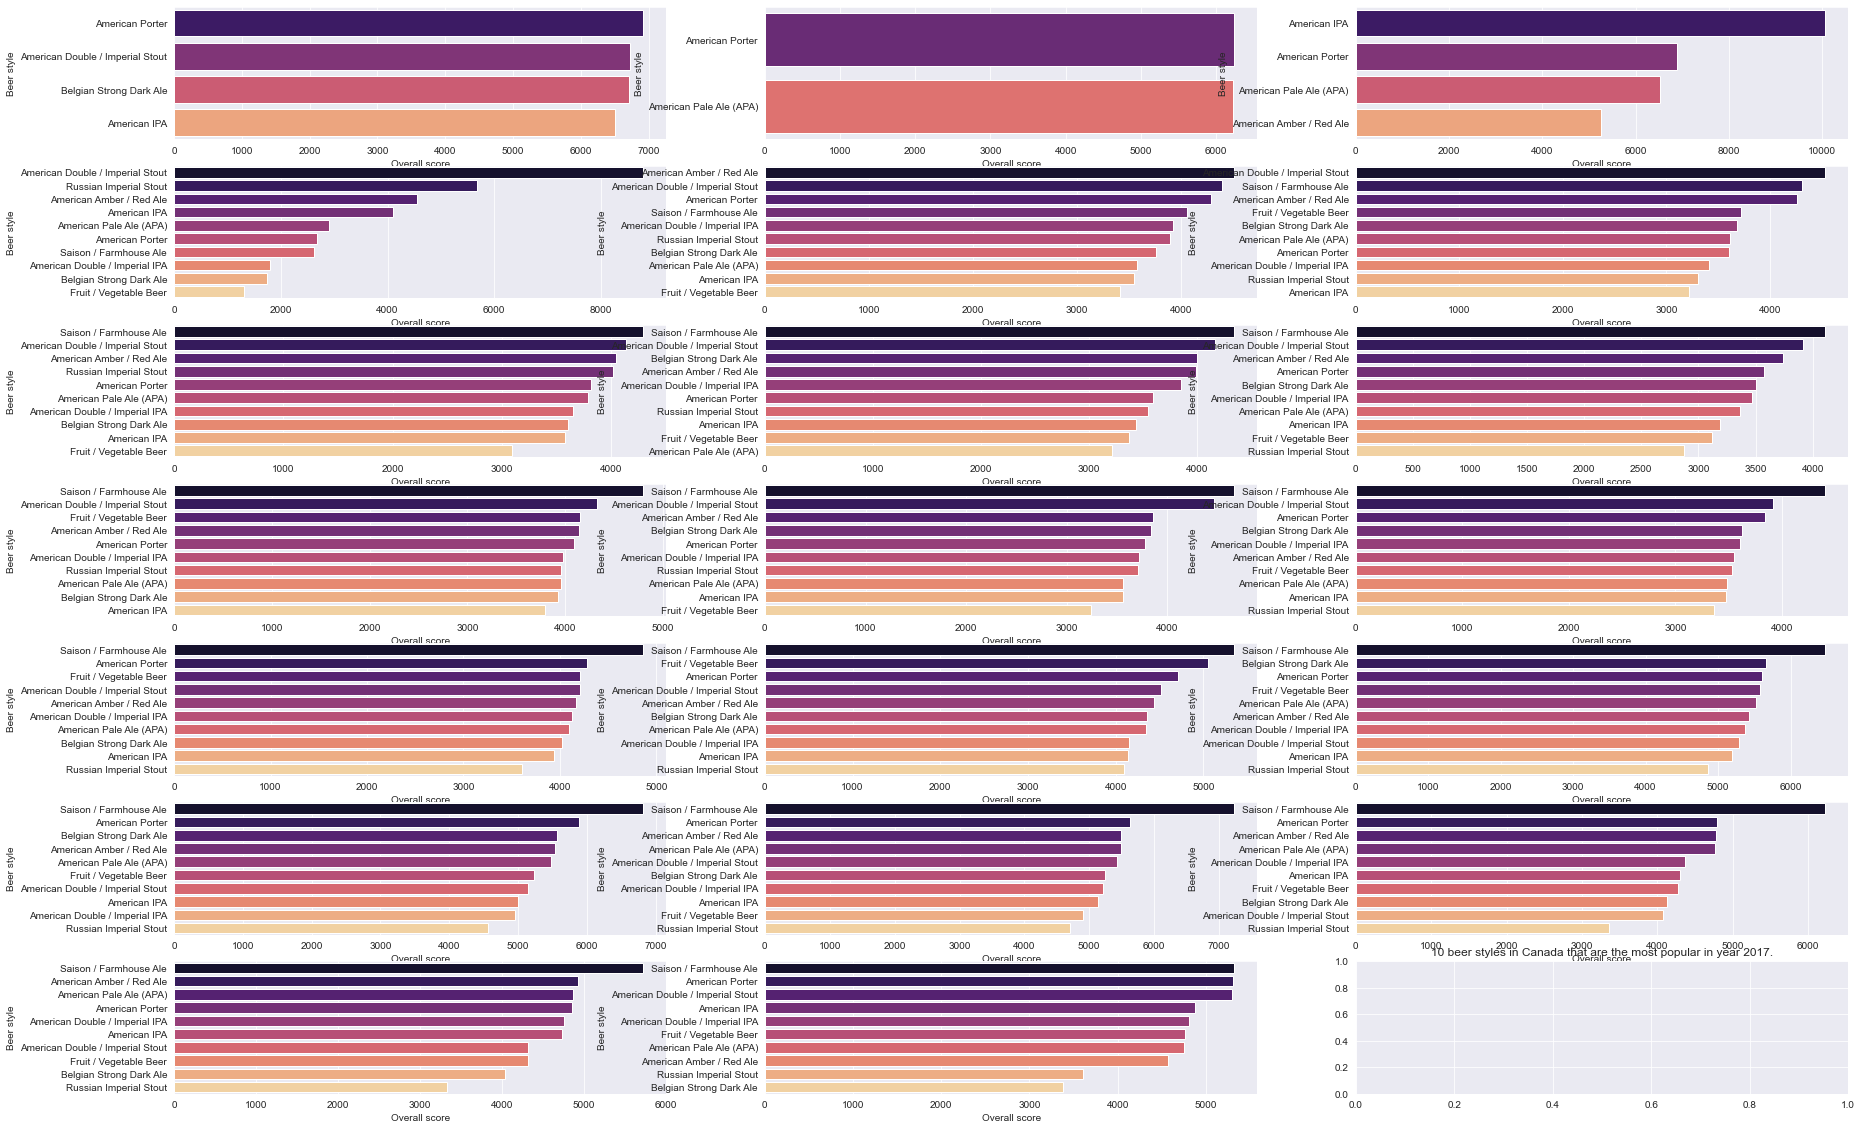

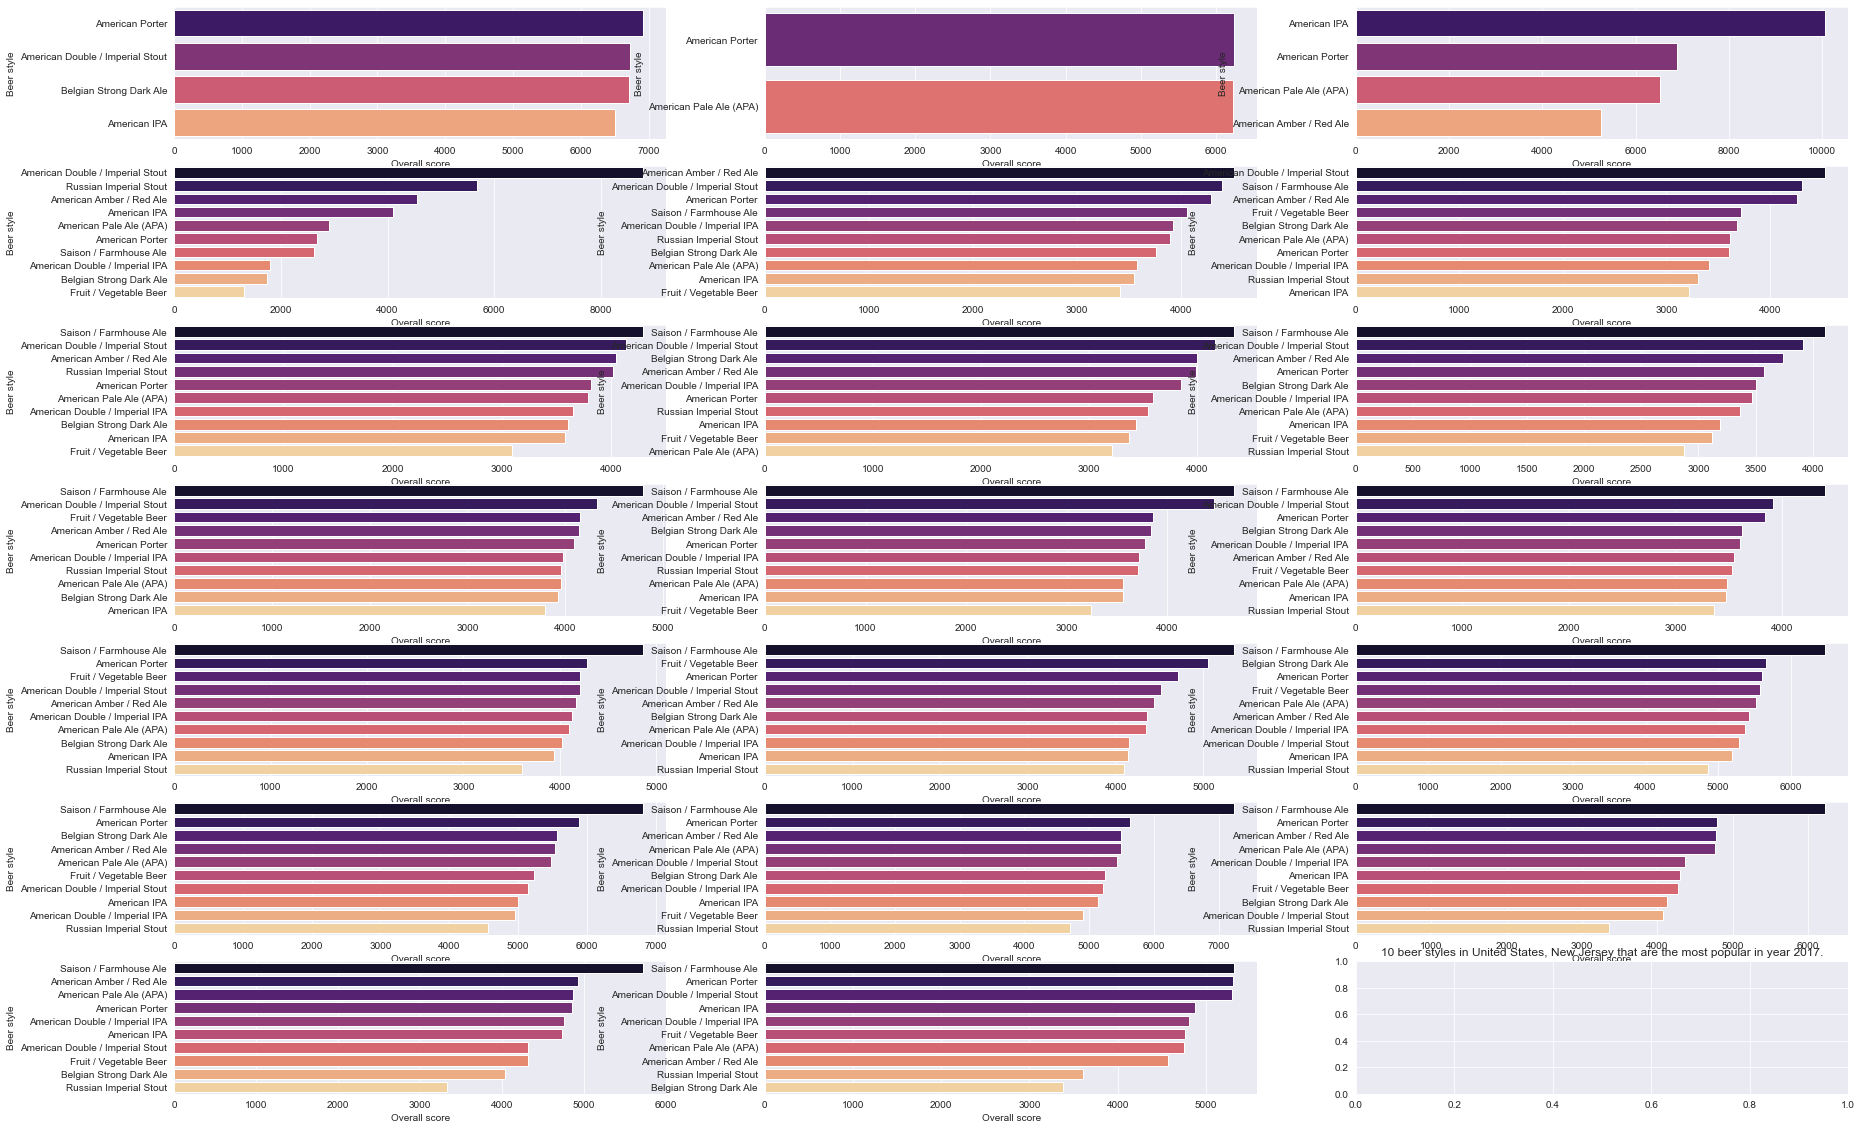

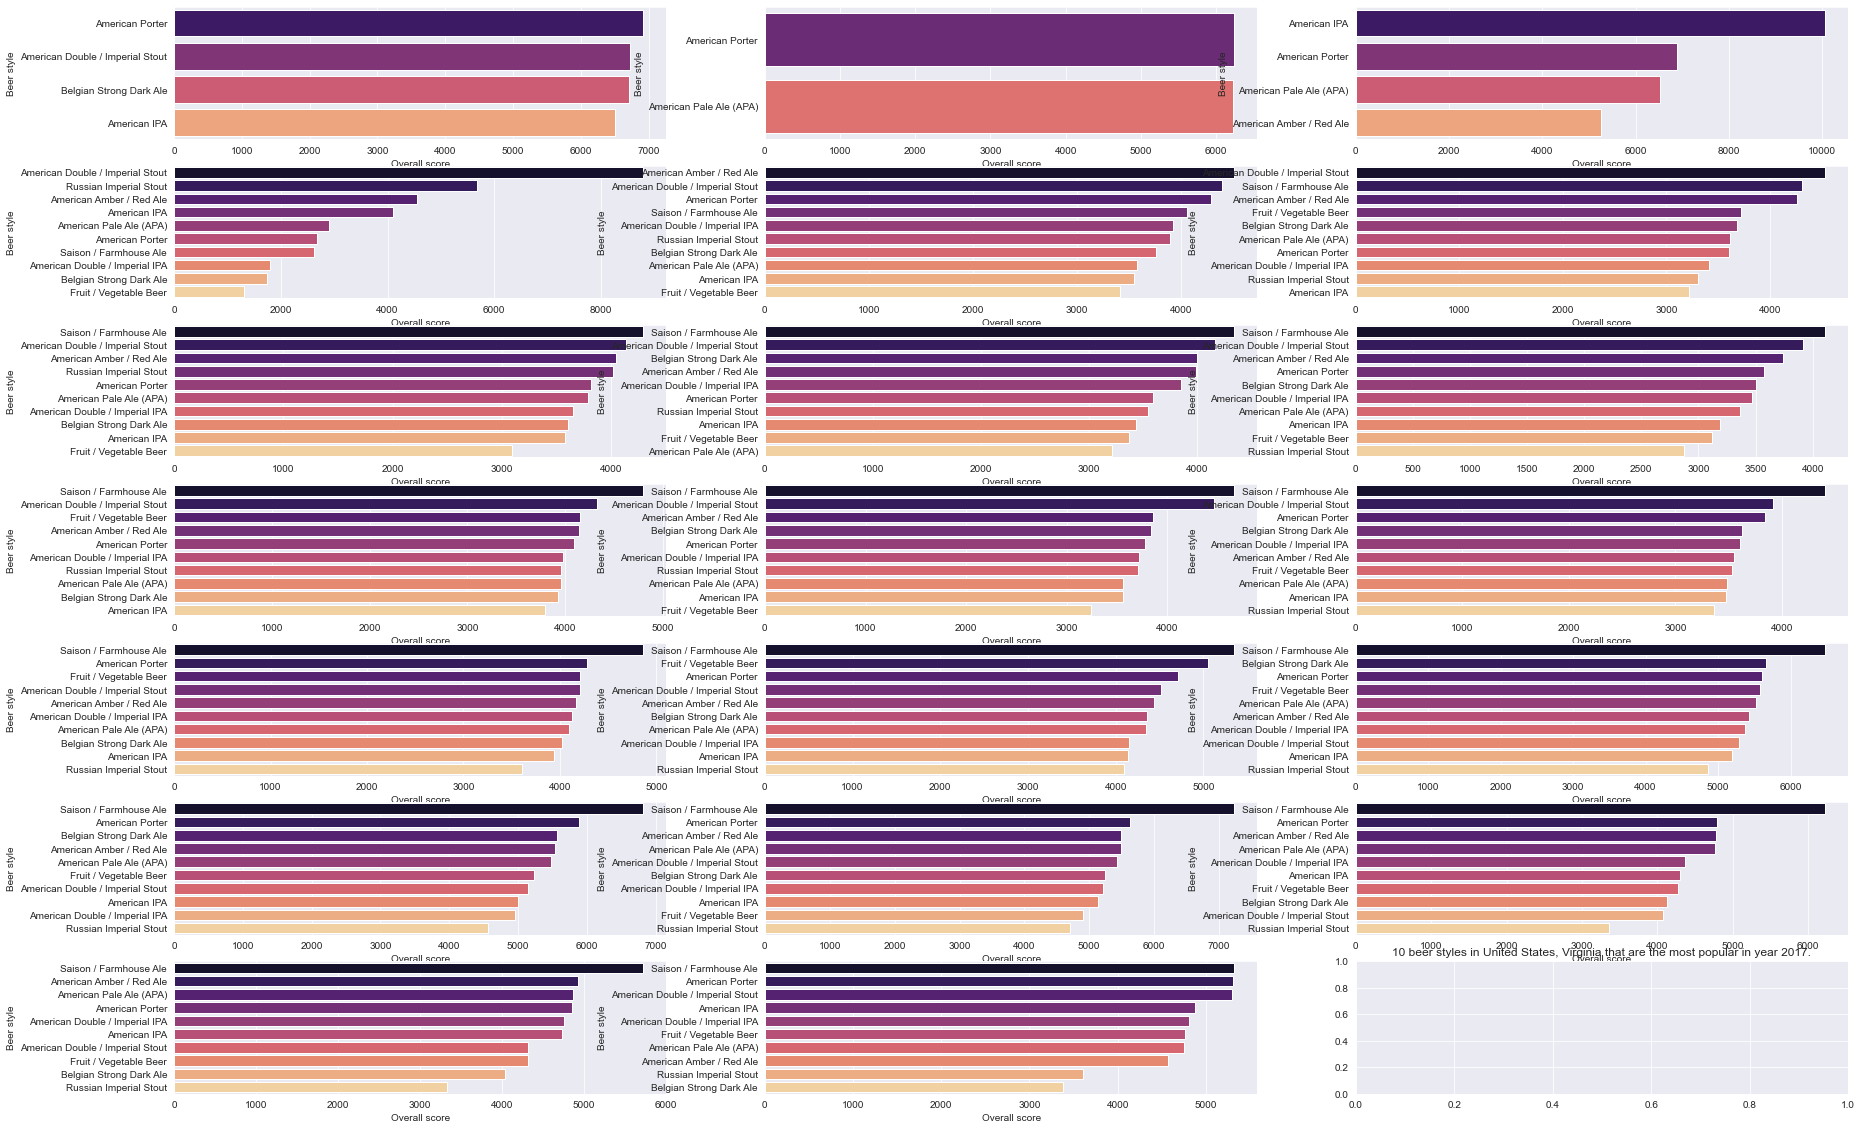

In [61]:
for region in region_agg.location[:10]:
    # print(region)
    fig, ax = plt.subplots(7 ,3, figsize = (30, 20))
    for idx, year in enumerate(year_list):
        # print(year)
        plot_interactive(region, year, ax[math.floor(idx//3), idx%3])

In [63]:
!pip install bar_chart_race

In [64]:
import bar_chart_race as bcr

In [65]:
region = region_agg.location[0]

In [66]:
df_race = region_ba_style_change[(region_ba_style_change.location==region)][['brewery_name', 'style','preference', 'date']]

NameError: name 'region_ba_style_change' is not defined

In [67]:
!pip install ffmpeg

In [68]:
df_race[['date','preference']]

NameError: name 'df_race' is not defined

In [ ]:
bcr.bar_chart_race(df_race[['date','preference']])